In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, Bidirectional, Reshape, Conv1D, GaussianNoise, BatchNormalization
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [8]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [10]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    lstm = Bidirectional(LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal'))
    lstm_1 = lstm(inputs)
    batch_norm1 = BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1)
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = Bidirectional(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal'))
    lstm_2_output = lstm_2(lstm_1_droput)
    batch_norm2 = BatchNormalization()(lstm_2_output)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2)
    lstm_2_dropout = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model


## Discriminator

In [11]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [12]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [13]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        # Threshhold
#         if(cur_gen_loss > 0.8):
#                 break;

    return history, history_val

## Visualization

In [14]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [15]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [16]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [17]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [18]:
stock_code = "AMZN"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    3.628125    3.631250    3.278125    3.459375    3.459375   
6    2000-01-11    3.343750    3.500000    3.250000    3.337500    3.337500   
7    2000-01-12    3.393750    3.400000    3.150000    3.178125    3.178125   
8    2000-01-13    3.246875    3.359375    3.156250    3.296875    3.296875   
9    2000-01-14    3.337500    3.431250    3.200000    3.212500    3.212500   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  160.250000  160.506500  159.208496  159.263504  159.263504   
5279 2020-12-24  159.695007  160.100006  158.449997  158.634506  158.634506   
5280 2020-12-28  159.699997  165.199997  158.634506  164.197998  164.197998   
5281 2020-12-29  165.496994  167.532501  164.061005  166.100006  166.100006   
5282 2020-12-30  167.050003  167.104996  164.123505  164.292496  164.292496   

         Volume          Ma  
5     295158000    3.761875  
6     210654000    3.560000  
7     216090000    3.408125  
8     208962000    3.346250  
9     137072000    3.350000  
...         ...         ...  
5278   41876000  160.913904  
5279   29038000  160.357004  
5280  113736000  159.723105  
5281   97458000  160.546204  
5282   64186000  161.704404  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 20)            1440      
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5, 20)            80        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 20)             0         
                                                                 
 dropout (Dropout)           (None, 5, 20)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480  

Time for epoch 52 is 0.8811545372009277 sec Generator Loss: 0.8251305818557739,  Discriminator_loss: 1.3420721292495728
Time for epoch 53 is 0.8925669193267822 sec Generator Loss: 0.8381237983703613,  Discriminator_loss: 1.33266019821167
Time for epoch 54 is 0.8846745491027832 sec Generator Loss: 0.8367422819137573,  Discriminator_loss: 1.3425747156143188
Time for epoch 55 is 0.8995637893676758 sec Generator Loss: 0.8049746751785278,  Discriminator_loss: 1.3628848791122437
Time for epoch 56 is 0.8895540237426758 sec Generator Loss: 0.8024851083755493,  Discriminator_loss: 1.3596525192260742
Time for epoch 57 is 0.9760417938232422 sec Generator Loss: 0.8144497275352478,  Discriminator_loss: 1.3644155263900757
Time for epoch 58 is 0.9379572868347168 sec Generator Loss: 0.8148351311683655,  Discriminator_loss: 1.3544211387634277
Time for epoch 59 is 0.9465208053588867 sec Generator Loss: 0.8097870945930481,  Discriminator_loss: 1.3531484603881836
Time for epoch 60 is 0.9694342613220215 se

Time for epoch 121 is 0.897050142288208 sec Generator Loss: 0.8149626851081848,  Discriminator_loss: 1.352805256843567
Time for epoch 122 is 0.9162337779998779 sec Generator Loss: 0.8054903149604797,  Discriminator_loss: 1.352907419204712
Time for epoch 123 is 0.886176586151123 sec Generator Loss: 0.7997867465019226,  Discriminator_loss: 1.3534799814224243
Time for epoch 124 is 0.8947482109069824 sec Generator Loss: 0.7964380979537964,  Discriminator_loss: 1.3497647047042847
Time for epoch 125 is 0.8909146785736084 sec Generator Loss: 0.8179988265037537,  Discriminator_loss: 1.3510562181472778
Time for epoch 126 is 0.9217731952667236 sec Generator Loss: 0.8336822390556335,  Discriminator_loss: 1.355737328529358
Time for epoch 127 is 0.9139506816864014 sec Generator Loss: 0.7871459722518921,  Discriminator_loss: 1.3605172634124756
Time for epoch 128 is 0.8886373043060303 sec Generator Loss: 0.80951327085495,  Discriminator_loss: 1.3577735424041748
Time for epoch 129 is 0.891064882278442

Time for epoch 189 is 0.8880701065063477 sec Generator Loss: 0.7986458539962769,  Discriminator_loss: 1.362691044807434
Time for epoch 190 is 0.8910536766052246 sec Generator Loss: 0.817477822303772,  Discriminator_loss: 1.355596661567688
Time for epoch 191 is 0.8972029685974121 sec Generator Loss: 0.7928190231323242,  Discriminator_loss: 1.3581347465515137
Time for epoch 192 is 0.8901886940002441 sec Generator Loss: 0.8196777701377869,  Discriminator_loss: 1.3541295528411865
Time for epoch 193 is 0.8988528251647949 sec Generator Loss: 0.8049942851066589,  Discriminator_loss: 1.362167477607727
Time for epoch 194 is 0.9265151023864746 sec Generator Loss: 0.7909632325172424,  Discriminator_loss: 1.3532658815383911
Time for epoch 195 is 0.8956713676452637 sec Generator Loss: 0.7819344401359558,  Discriminator_loss: 1.360155701637268
Time for epoch 196 is 0.9050571918487549 sec Generator Loss: 0.798382043838501,  Discriminator_loss: 1.3618359565734863
Time for epoch 197 is 0.92485046386718

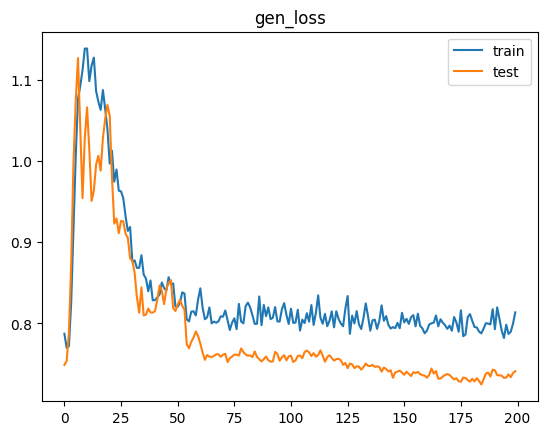

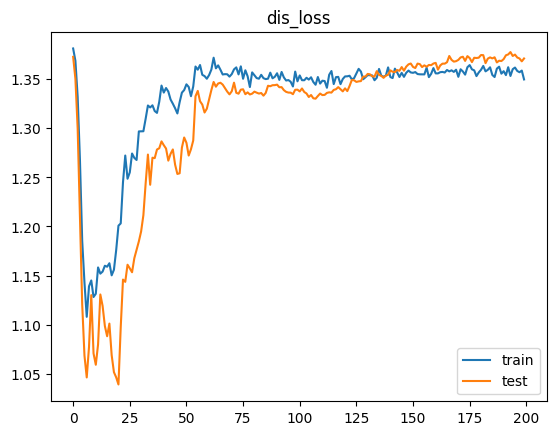

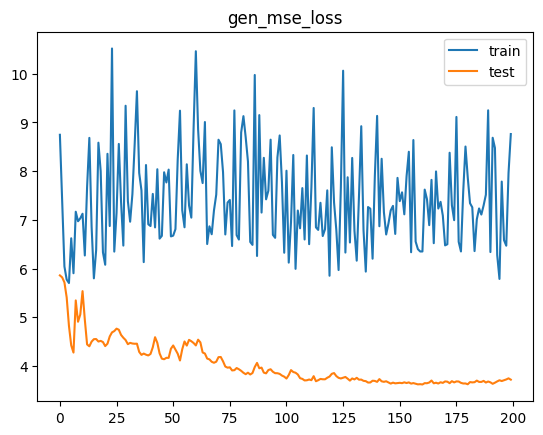

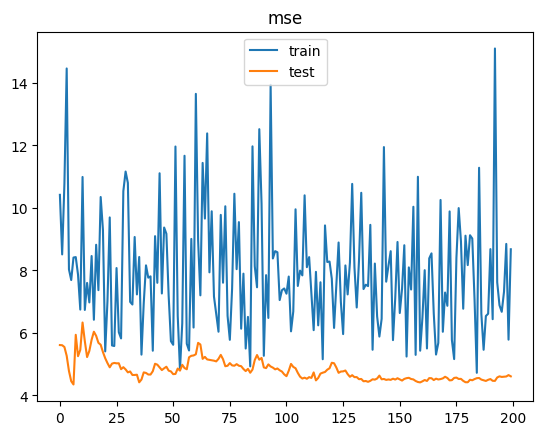

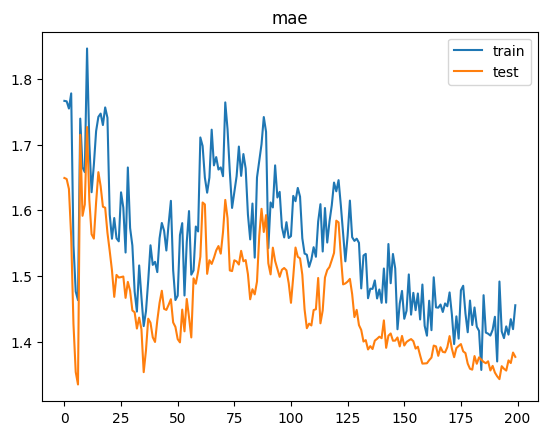

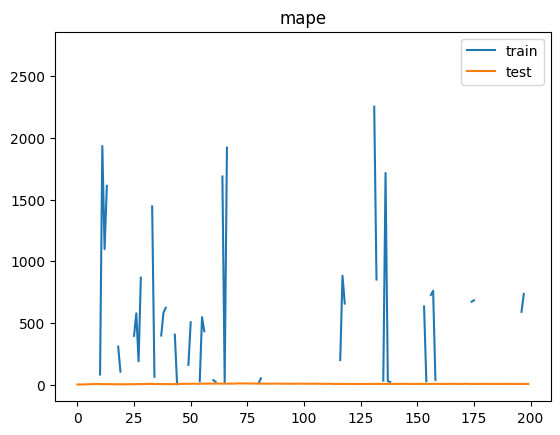

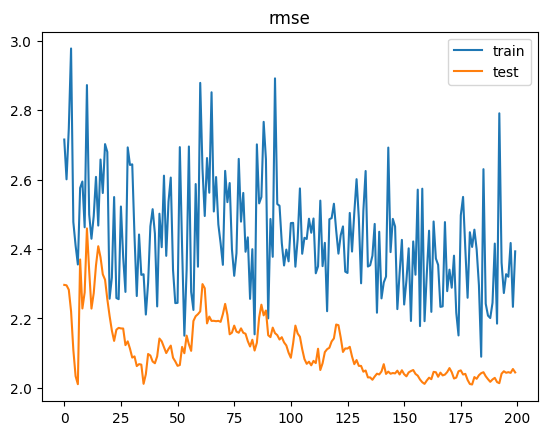

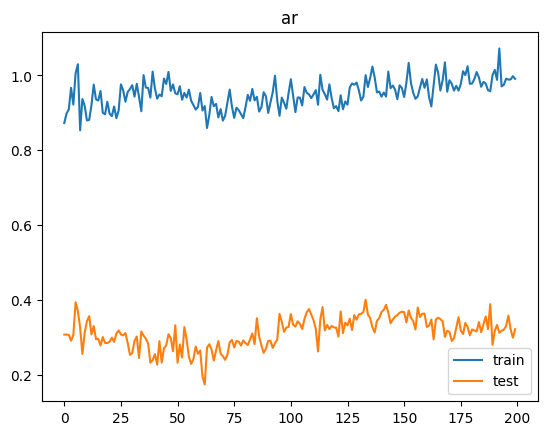

2/2 [==============================] - 1s 3ms/step


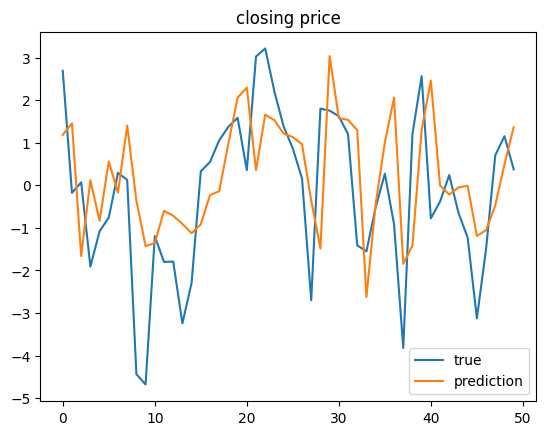

[MSE Baseline] train: 5.427535781934391  test: 4.137918162168212
Delta time with epochs = 200: 0:03:12.221467
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 20)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 20)             0         
               

Time for epoch 51 is 0.8959574699401855 sec Generator Loss: 0.8148449659347534,  Discriminator_loss: 1.3567866086959839
Time for epoch 52 is 0.902977466583252 sec Generator Loss: 0.8031468987464905,  Discriminator_loss: 1.3537418842315674
Time for epoch 53 is 0.9095637798309326 sec Generator Loss: 0.8138782978057861,  Discriminator_loss: 1.356826663017273
Time for epoch 54 is 0.9022252559661865 sec Generator Loss: 0.8180108666419983,  Discriminator_loss: 1.3485307693481445
Time for epoch 55 is 0.9094021320343018 sec Generator Loss: 0.8115577697753906,  Discriminator_loss: 1.3536901473999023
Time for epoch 56 is 0.8997998237609863 sec Generator Loss: 0.8151869177818298,  Discriminator_loss: 1.350264549255371
Time for epoch 57 is 0.9058594703674316 sec Generator Loss: 0.8089758157730103,  Discriminator_loss: 1.3519976139068604
Time for epoch 58 is 0.8669114112854004 sec Generator Loss: 0.8016793131828308,  Discriminator_loss: 1.3551355600357056
Time for epoch 59 is 0.9043691158294678 sec

Time for epoch 120 is 0.9087691307067871 sec Generator Loss: 0.8350906372070312,  Discriminator_loss: 1.348225712776184
Time for epoch 121 is 0.8912413120269775 sec Generator Loss: 0.7971910834312439,  Discriminator_loss: 1.3496177196502686
Time for epoch 122 is 0.8998725414276123 sec Generator Loss: 0.8071776628494263,  Discriminator_loss: 1.3498759269714355
Time for epoch 123 is 0.8892598152160645 sec Generator Loss: 0.805461585521698,  Discriminator_loss: 1.35071861743927
Time for epoch 124 is 0.8955683708190918 sec Generator Loss: 0.7937919497489929,  Discriminator_loss: 1.350610375404358
Time for epoch 125 is 0.8981790542602539 sec Generator Loss: 0.8139709830284119,  Discriminator_loss: 1.3521980047225952
Time for epoch 126 is 0.8897156715393066 sec Generator Loss: 0.8106749653816223,  Discriminator_loss: 1.3481926918029785
Time for epoch 127 is 0.8904109001159668 sec Generator Loss: 0.8065015077590942,  Discriminator_loss: 1.349088191986084
Time for epoch 128 is 0.88903164863586

Time for epoch 189 is 0.9376318454742432 sec Generator Loss: 0.7968431115150452,  Discriminator_loss: 1.358896255493164
Time for epoch 190 is 0.9441690444946289 sec Generator Loss: 0.8123158812522888,  Discriminator_loss: 1.3598581552505493
Time for epoch 191 is 0.9243559837341309 sec Generator Loss: 0.8399527072906494,  Discriminator_loss: 1.3572746515274048
Time for epoch 192 is 0.9112746715545654 sec Generator Loss: 0.7825509905815125,  Discriminator_loss: 1.3638474941253662
Time for epoch 193 is 0.9057207107543945 sec Generator Loss: 0.794418454170227,  Discriminator_loss: 1.3568845987319946
Time for epoch 194 is 0.9255406856536865 sec Generator Loss: 0.7935888767242432,  Discriminator_loss: 1.3596283197402954
Time for epoch 195 is 0.9100971221923828 sec Generator Loss: 0.7962398529052734,  Discriminator_loss: 1.3577653169631958
Time for epoch 196 is 0.8975577354431152 sec Generator Loss: 0.8042555451393127,  Discriminator_loss: 1.356257438659668
Time for epoch 197 is 0.90337848663

Time for epoch 257 is 0.9145567417144775 sec Generator Loss: 0.8070623278617859,  Discriminator_loss: 1.3566431999206543
Time for epoch 258 is 0.9055776596069336 sec Generator Loss: 0.7872233986854553,  Discriminator_loss: 1.357840895652771
Time for epoch 259 is 0.8999874591827393 sec Generator Loss: 0.803631603717804,  Discriminator_loss: 1.3577373027801514
Time for epoch 260 is 0.9107322692871094 sec Generator Loss: 0.7934479713439941,  Discriminator_loss: 1.3625398874282837
Time for epoch 261 is 0.8988511562347412 sec Generator Loss: 0.8001755475997925,  Discriminator_loss: 1.3563919067382812
Time for epoch 262 is 0.8953115940093994 sec Generator Loss: 0.8129059076309204,  Discriminator_loss: 1.3466500043869019
Time for epoch 263 is 0.8940856456756592 sec Generator Loss: 0.801338255405426,  Discriminator_loss: 1.358940839767456
Time for epoch 264 is 0.8957247734069824 sec Generator Loss: 0.799403965473175,  Discriminator_loss: 1.349821925163269
Time for epoch 265 is 0.89994478225708

Time for epoch 325 is 0.885645866394043 sec Generator Loss: 0.8148971796035767,  Discriminator_loss: 1.3512929677963257
Time for epoch 326 is 0.8909006118774414 sec Generator Loss: 0.8010696172714233,  Discriminator_loss: 1.3542861938476562
Time for epoch 327 is 1.0111546516418457 sec Generator Loss: 0.813431441783905,  Discriminator_loss: 1.3428276777267456
Time for epoch 328 is 0.8803305625915527 sec Generator Loss: 0.8202213644981384,  Discriminator_loss: 1.3471592664718628
Time for epoch 329 is 0.8844799995422363 sec Generator Loss: 0.7929417490959167,  Discriminator_loss: 1.3574180603027344
Time for epoch 330 is 0.903148889541626 sec Generator Loss: 0.8229742050170898,  Discriminator_loss: 1.3482372760772705
Time for epoch 331 is 0.9068582057952881 sec Generator Loss: 0.800398051738739,  Discriminator_loss: 1.3402736186981201
Time for epoch 332 is 0.9961445331573486 sec Generator Loss: 0.8086162805557251,  Discriminator_loss: 1.3433705568313599
Time for epoch 333 is 0.975541114807

Time for epoch 394 is 0.9268641471862793 sec Generator Loss: 0.8257516622543335,  Discriminator_loss: 1.344048023223877
Time for epoch 395 is 0.9294881820678711 sec Generator Loss: 0.8086208701133728,  Discriminator_loss: 1.3458598852157593
Time for epoch 396 is 0.9271447658538818 sec Generator Loss: 0.8065443634986877,  Discriminator_loss: 1.3473529815673828
Time for epoch 397 is 0.91845703125 sec Generator Loss: 0.8100425004959106,  Discriminator_loss: 1.343717098236084
Time for epoch 398 is 0.9165797233581543 sec Generator Loss: 0.8133280873298645,  Discriminator_loss: 1.3430782556533813
Time for epoch 399 is 0.9157490730285645 sec Generator Loss: 0.8102678060531616,  Discriminator_loss: 1.3558214902877808
Time for epoch 400 is 0.9286937713623047 sec Generator Loss: 0.8370538353919983,  Discriminator_loss: 1.3377721309661865
Time for epoch 401 is 0.9236409664154053 sec Generator Loss: 0.8028602004051208,  Discriminator_loss: 1.3445292711257935
Time for epoch 402 is 0.922725677490234

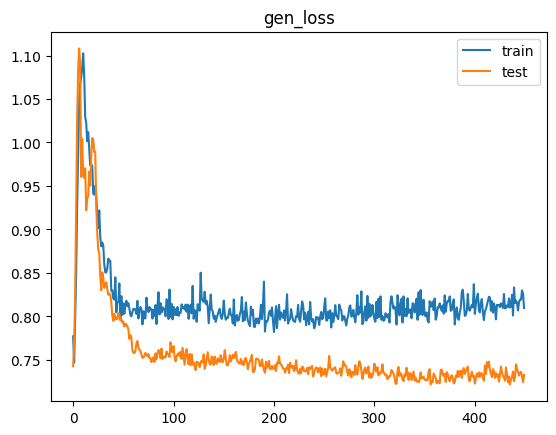

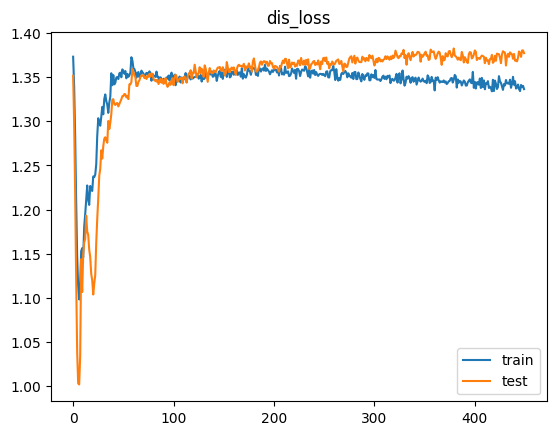

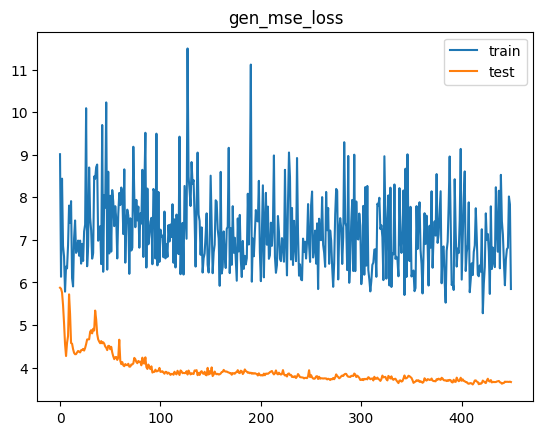

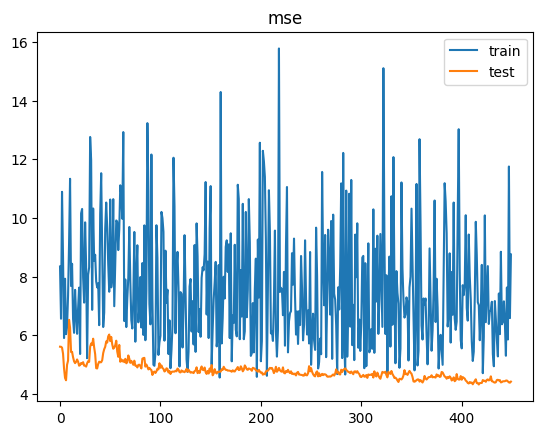

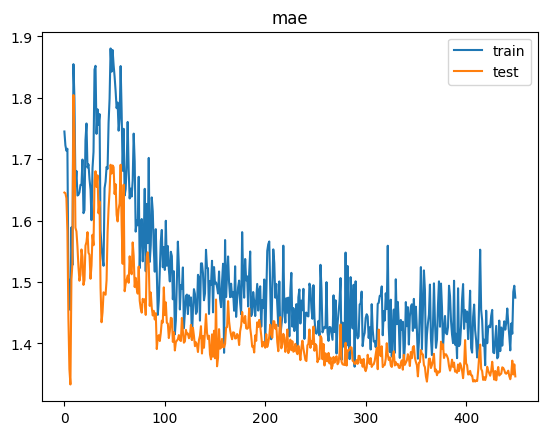

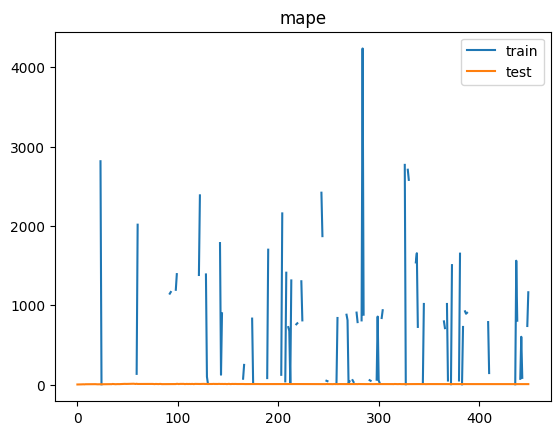

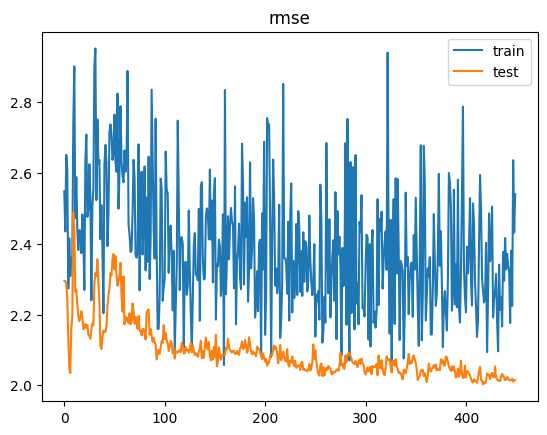

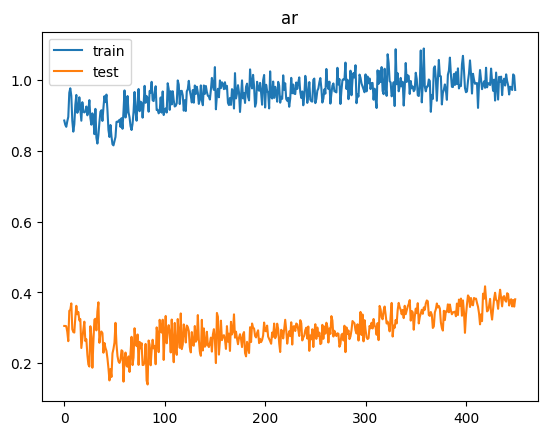

2/2 [==============================] - 1s 4ms/step


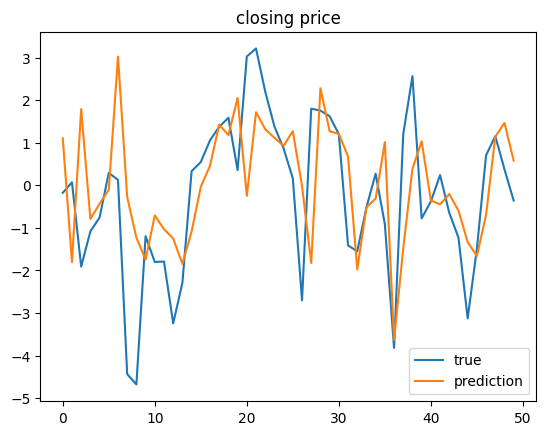

[MSE Baseline] train: 8.914360398689913  test: 4.1521541466081695
Delta time with epochs = 450: 0:07:23.134040
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 1.0094630718231201 sec Generator Loss: 0.8267869353294373,  Discriminator_loss: 1.3472676277160645
Time for epoch 52 is 1.0067451000213623 sec Generator Loss: 0.8134028911590576,  Discriminator_loss: 1.3500010967254639
Time for epoch 53 is 1.0044176578521729 sec Generator Loss: 0.8168113231658936,  Discriminator_loss: 1.350841999053955
Time for epoch 54 is 1.2368123531341553 sec Generator Loss: 0.8204585313796997,  Discriminator_loss: 1.3508665561676025
Time for epoch 55 is 0.9691751003265381 sec Generator Loss: 0.8023810982704163,  Discriminator_loss: 1.3531829118728638
Time for epoch 56 is 0.9697747230529785 sec Generator Loss: 0.8226906061172485,  Discriminator_loss: 1.3440948724746704
Time for epoch 57 is 0.9117424488067627 sec Generator Loss: 0.8029123544692993,  Discriminator_loss: 1.3499886989593506
Time for epoch 58 is 0.8917150497436523 sec Generator Loss: 0.8327367901802063,  Discriminator_loss: 1.3407541513442993
Time for epoch 59 is 0.9059643745422363 s

Time for epoch 120 is 1.0556297302246094 sec Generator Loss: 0.8295187950134277,  Discriminator_loss: 1.3440754413604736
Time for epoch 121 is 1.0183210372924805 sec Generator Loss: 0.8059736490249634,  Discriminator_loss: 1.354129672050476
Time for epoch 122 is 0.9826397895812988 sec Generator Loss: 0.7990203499794006,  Discriminator_loss: 1.356594204902649
Time for epoch 123 is 0.9961893558502197 sec Generator Loss: 0.7991475462913513,  Discriminator_loss: 1.350226640701294
Time for epoch 124 is 0.9757125377655029 sec Generator Loss: 0.8083668351173401,  Discriminator_loss: 1.350866436958313
Time for epoch 125 is 1.0044841766357422 sec Generator Loss: 0.8105825781822205,  Discriminator_loss: 1.349875807762146
Time for epoch 126 is 1.1447865962982178 sec Generator Loss: 0.806572675704956,  Discriminator_loss: 1.350844144821167
Time for epoch 127 is 1.0710864067077637 sec Generator Loss: 0.7874439358711243,  Discriminator_loss: 1.3529093265533447
Time for epoch 128 is 1.169878005981445

Time for epoch 188 is 0.8928413391113281 sec Generator Loss: 0.8010252118110657,  Discriminator_loss: 1.354947805404663
Time for epoch 189 is 0.9182405471801758 sec Generator Loss: 0.7937644124031067,  Discriminator_loss: 1.345937728881836
Time for epoch 190 is 0.9376943111419678 sec Generator Loss: 0.8029658198356628,  Discriminator_loss: 1.3422455787658691
Time for epoch 191 is 0.9250059127807617 sec Generator Loss: 0.8004289865493774,  Discriminator_loss: 1.34696626663208
Time for epoch 192 is 0.9696729183197021 sec Generator Loss: 0.8253200650215149,  Discriminator_loss: 1.3486342430114746
Time for epoch 193 is 1.0835719108581543 sec Generator Loss: 0.7994691133499146,  Discriminator_loss: 1.3487440347671509
Time for epoch 194 is 0.9269747734069824 sec Generator Loss: 0.7903013229370117,  Discriminator_loss: 1.3518059253692627
Time for epoch 195 is 0.89591383934021 sec Generator Loss: 0.7984600067138672,  Discriminator_loss: 1.3519574403762817
Time for epoch 196 is 0.89646744728088

Time for epoch 256 is 0.887488603591919 sec Generator Loss: 0.8232021331787109,  Discriminator_loss: 1.3550809621810913
Time for epoch 257 is 0.8996188640594482 sec Generator Loss: 0.8089274168014526,  Discriminator_loss: 1.346280813217163
Time for epoch 258 is 0.8907384872436523 sec Generator Loss: 0.7964093685150146,  Discriminator_loss: 1.35525643825531
Time for epoch 259 is 0.8992259502410889 sec Generator Loss: 0.8170653581619263,  Discriminator_loss: 1.3501795530319214
Time for epoch 260 is 0.919797420501709 sec Generator Loss: 0.794670820236206,  Discriminator_loss: 1.3509048223495483
Time for epoch 261 is 0.8914523124694824 sec Generator Loss: 0.7980551719665527,  Discriminator_loss: 1.3439534902572632
Time for epoch 262 is 0.8908908367156982 sec Generator Loss: 0.8050702810287476,  Discriminator_loss: 1.3474910259246826
Time for epoch 263 is 0.896888256072998 sec Generator Loss: 0.8131187558174133,  Discriminator_loss: 1.3485050201416016
Time for epoch 264 is 0.901698350906372

Time for epoch 325 is 0.8870015144348145 sec Generator Loss: 0.8018354177474976,  Discriminator_loss: 1.3503831624984741
Time for epoch 326 is 0.8927140235900879 sec Generator Loss: 0.8029988408088684,  Discriminator_loss: 1.345404028892517
Time for epoch 327 is 0.8859374523162842 sec Generator Loss: 0.8046624660491943,  Discriminator_loss: 1.3531651496887207
Time for epoch 328 is 0.8960049152374268 sec Generator Loss: 0.8111071586608887,  Discriminator_loss: 1.3485825061798096
Time for epoch 329 is 0.8888163566589355 sec Generator Loss: 0.7983070015907288,  Discriminator_loss: 1.3439849615097046
Time for epoch 330 is 0.902015209197998 sec Generator Loss: 0.806035041809082,  Discriminator_loss: 1.3473032712936401
Time for epoch 331 is 0.8884773254394531 sec Generator Loss: 0.8179446458816528,  Discriminator_loss: 1.3412648439407349
Time for epoch 332 is 0.895111083984375 sec Generator Loss: 0.8015041947364807,  Discriminator_loss: 1.3460278511047363
Time for epoch 333 is 0.888740301132

Time for epoch 393 is 0.8784358501434326 sec Generator Loss: 0.8095433115959167,  Discriminator_loss: 1.344821810722351
Time for epoch 394 is 0.8846259117126465 sec Generator Loss: 0.7942225337028503,  Discriminator_loss: 1.346293330192566
Time for epoch 395 is 0.8896098136901855 sec Generator Loss: 0.8178646564483643,  Discriminator_loss: 1.3469699621200562
Time for epoch 396 is 0.8919658660888672 sec Generator Loss: 0.8058770298957825,  Discriminator_loss: 1.3460094928741455
Time for epoch 397 is 0.880049467086792 sec Generator Loss: 0.8101479411125183,  Discriminator_loss: 1.3442820310592651
Time for epoch 398 is 0.876676082611084 sec Generator Loss: 0.8231489062309265,  Discriminator_loss: 1.3483697175979614
Time for epoch 399 is 0.8758325576782227 sec Generator Loss: 0.7997839450836182,  Discriminator_loss: 1.341044545173645
Time for epoch 400 is 0.8741202354431152 sec Generator Loss: 0.7986801862716675,  Discriminator_loss: 1.3437434434890747
Time for epoch 401 is 0.9097824096679

Time for epoch 461 is 0.880805253982544 sec Generator Loss: 0.8200525045394897,  Discriminator_loss: 1.3471276760101318
Time for epoch 462 is 0.9257886409759521 sec Generator Loss: 0.8099207878112793,  Discriminator_loss: 1.3491523265838623
Time for epoch 463 is 0.9286282062530518 sec Generator Loss: 0.8103400468826294,  Discriminator_loss: 1.3440477848052979
Time for epoch 464 is 0.9016525745391846 sec Generator Loss: 0.8035510182380676,  Discriminator_loss: 1.3459781408309937
Time for epoch 465 is 0.8884549140930176 sec Generator Loss: 0.8151226043701172,  Discriminator_loss: 1.3443734645843506
Time for epoch 466 is 0.8844931125640869 sec Generator Loss: 0.8126598596572876,  Discriminator_loss: 1.337221622467041
Time for epoch 467 is 0.9202630519866943 sec Generator Loss: 0.8253241181373596,  Discriminator_loss: 1.3397600650787354
Time for epoch 468 is 0.8973510265350342 sec Generator Loss: 0.8146052360534668,  Discriminator_loss: 1.3410232067108154
Time for epoch 469 is 0.8837492465

Time for epoch 530 is 0.9268460273742676 sec Generator Loss: 0.8043931722640991,  Discriminator_loss: 1.3408088684082031
Time for epoch 531 is 0.8883755207061768 sec Generator Loss: 0.8152329325675964,  Discriminator_loss: 1.3414558172225952
Time for epoch 532 is 0.8871996402740479 sec Generator Loss: 0.8075286746025085,  Discriminator_loss: 1.3455909490585327
Time for epoch 533 is 0.8899998664855957 sec Generator Loss: 0.8123534917831421,  Discriminator_loss: 1.3372780084609985
Time for epoch 534 is 0.8919713497161865 sec Generator Loss: 0.7972619533538818,  Discriminator_loss: 1.3480364084243774
Time for epoch 535 is 0.8907415866851807 sec Generator Loss: 0.8216864466667175,  Discriminator_loss: 1.3389356136322021
Time for epoch 536 is 0.8851094245910645 sec Generator Loss: 0.8126085996627808,  Discriminator_loss: 1.3344193696975708
Time for epoch 537 is 0.8873088359832764 sec Generator Loss: 0.8177888989448547,  Discriminator_loss: 1.3459196090698242
Time for epoch 538 is 0.89113211

Time for epoch 598 is 0.893625020980835 sec Generator Loss: 0.8140724301338196,  Discriminator_loss: 1.3411668539047241
Time for epoch 599 is 0.8937406539916992 sec Generator Loss: 0.8148812651634216,  Discriminator_loss: 1.342418909072876
Time for epoch 600 is 0.9084179401397705 sec Generator Loss: 0.811345100402832,  Discriminator_loss: 1.3374927043914795
Time for epoch 601 is 0.9281504154205322 sec Generator Loss: 0.8163802027702332,  Discriminator_loss: 1.3354337215423584
Time for epoch 602 is 0.935457706451416 sec Generator Loss: 0.8148817420005798,  Discriminator_loss: 1.347261667251587
Time for epoch 603 is 0.9701850414276123 sec Generator Loss: 0.8130353093147278,  Discriminator_loss: 1.3384474515914917
Time for epoch 604 is 0.9359538555145264 sec Generator Loss: 0.8067484498023987,  Discriminator_loss: 1.3475550413131714
Time for epoch 605 is 0.9419584274291992 sec Generator Loss: 0.8073424100875854,  Discriminator_loss: 1.3433313369750977
Time for epoch 606 is 0.9237337112426

Time for epoch 667 is 0.9111807346343994 sec Generator Loss: 0.8241264820098877,  Discriminator_loss: 1.3403958082199097
Time for epoch 668 is 0.8952133655548096 sec Generator Loss: 0.8144909739494324,  Discriminator_loss: 1.3429217338562012
Time for epoch 669 is 0.8940937519073486 sec Generator Loss: 0.8141361474990845,  Discriminator_loss: 1.342125415802002
Time for epoch 670 is 0.8966624736785889 sec Generator Loss: 0.8229946494102478,  Discriminator_loss: 1.3389509916305542
Time for epoch 671 is 0.8976800441741943 sec Generator Loss: 0.8283848762512207,  Discriminator_loss: 1.3382338285446167
Time for epoch 672 is 0.9022085666656494 sec Generator Loss: 0.8010804653167725,  Discriminator_loss: 1.347157597541809
Time for epoch 673 is 0.8993356227874756 sec Generator Loss: 0.8209534287452698,  Discriminator_loss: 1.3417797088623047
Time for epoch 674 is 0.9065430164337158 sec Generator Loss: 0.831285297870636,  Discriminator_loss: 1.3381534814834595
Time for epoch 675 is 0.89601755142

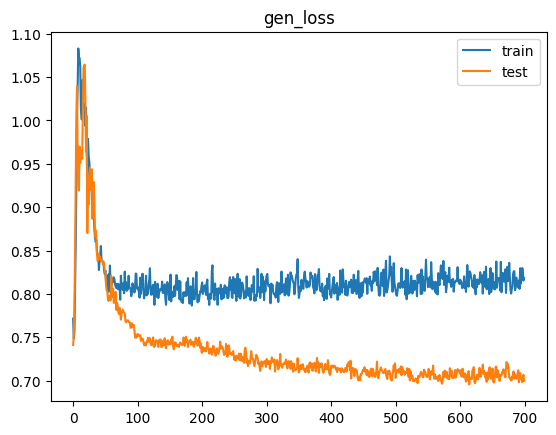

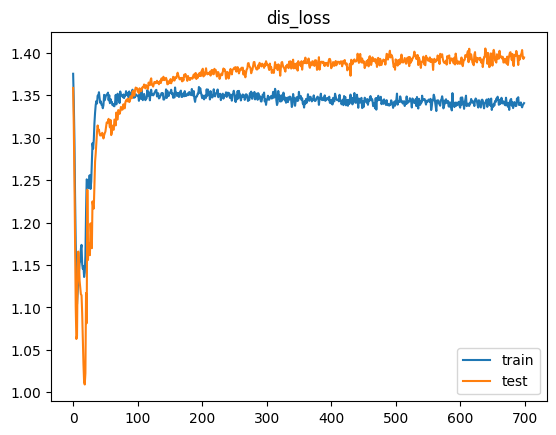

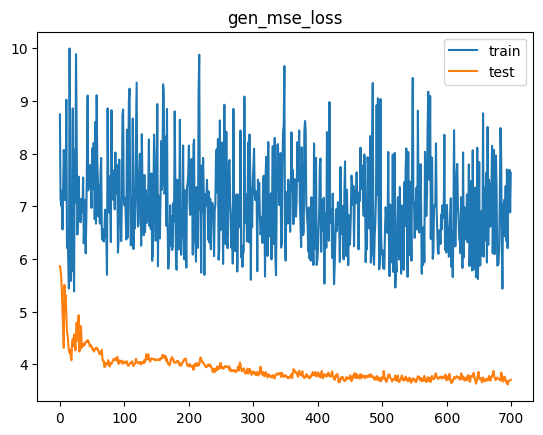

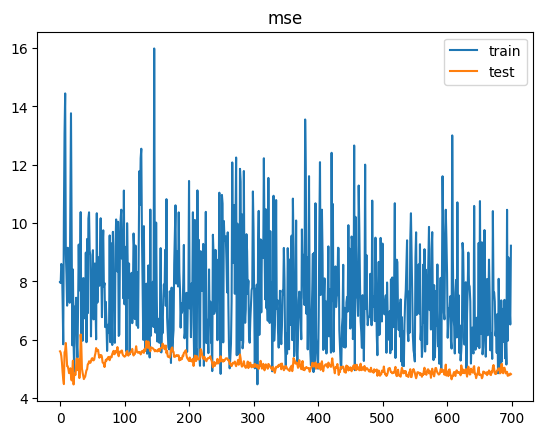

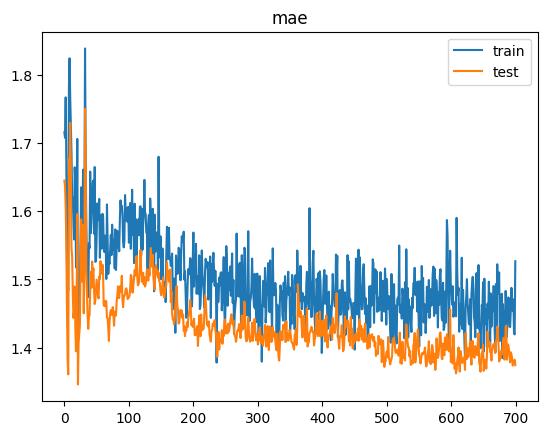

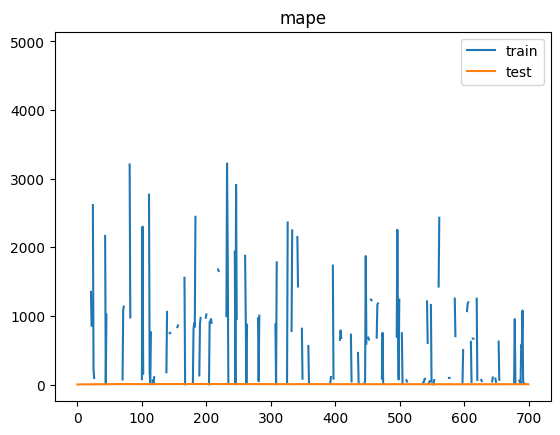

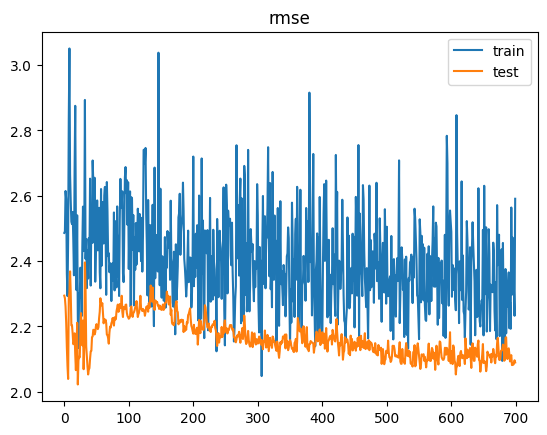

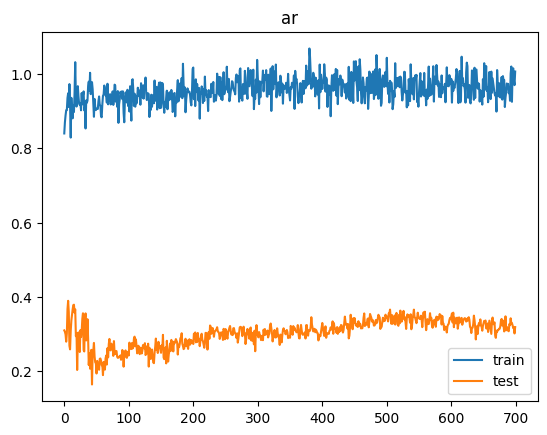

2/2 [==============================] - 1s 3ms/step


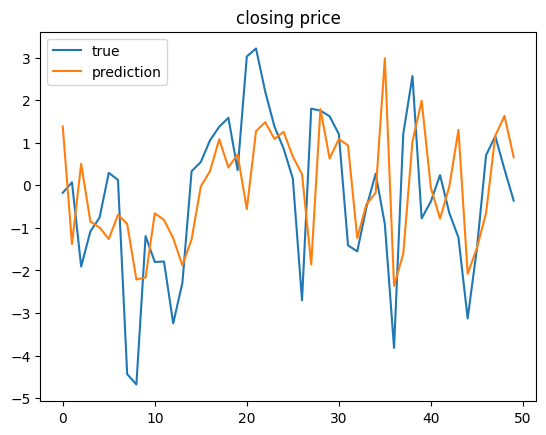

[MSE Baseline] train: 5.467956121624271  test: 4.1521541466081695
Delta time with epochs = 700: 0:11:03.364107
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 0.9044768810272217 sec Generator Loss: 0.8346441388130188,  Discriminator_loss: 1.3373541831970215
Time for epoch 52 is 0.897024393081665 sec Generator Loss: 0.8243602514266968,  Discriminator_loss: 1.330863118171692
Time for epoch 53 is 0.8899765014648438 sec Generator Loss: 0.8288803100585938,  Discriminator_loss: 1.3454902172088623
Time for epoch 54 is 0.8942396640777588 sec Generator Loss: 0.813815712928772,  Discriminator_loss: 1.3429547548294067
Time for epoch 55 is 0.8971750736236572 sec Generator Loss: 0.8064422011375427,  Discriminator_loss: 1.352837085723877
Time for epoch 56 is 0.9024324417114258 sec Generator Loss: 0.8180521130561829,  Discriminator_loss: 1.3570294380187988
Time for epoch 57 is 0.900479793548584 sec Generator Loss: 0.8172858357429504,  Discriminator_loss: 1.3623217344284058
Time for epoch 58 is 0.8942041397094727 sec Generator Loss: 0.8185833096504211,  Discriminator_loss: 1.3724251985549927
Time for epoch 59 is 0.9082472324371338 sec G

Time for epoch 120 is 0.8968489170074463 sec Generator Loss: 0.7873775959014893,  Discriminator_loss: 1.3577505350112915
Time for epoch 121 is 0.8978137969970703 sec Generator Loss: 0.8073627352714539,  Discriminator_loss: 1.3500350713729858
Time for epoch 122 is 0.9377353191375732 sec Generator Loss: 0.7843928337097168,  Discriminator_loss: 1.3574467897415161
Time for epoch 123 is 0.8996748924255371 sec Generator Loss: 0.8121766448020935,  Discriminator_loss: 1.3588751554489136
Time for epoch 124 is 0.891099214553833 sec Generator Loss: 0.7992784380912781,  Discriminator_loss: 1.3552721738815308
Time for epoch 125 is 0.8862075805664062 sec Generator Loss: 0.7982780337333679,  Discriminator_loss: 1.3507879972457886
Time for epoch 126 is 0.8884494304656982 sec Generator Loss: 0.8059845566749573,  Discriminator_loss: 1.3539531230926514
Time for epoch 127 is 0.8943102359771729 sec Generator Loss: 0.7955713868141174,  Discriminator_loss: 1.355398178100586
Time for epoch 128 is 0.9102892875

Time for epoch 189 is 0.9443984031677246 sec Generator Loss: 0.8094536066055298,  Discriminator_loss: 1.3549375534057617
Time for epoch 190 is 0.9198448657989502 sec Generator Loss: 0.7902515530586243,  Discriminator_loss: 1.3573665618896484
Time for epoch 191 is 0.8952672481536865 sec Generator Loss: 0.7853176593780518,  Discriminator_loss: 1.3557785749435425
Time for epoch 192 is 0.9229526519775391 sec Generator Loss: 0.8198477029800415,  Discriminator_loss: 1.3526725769042969
Time for epoch 193 is 0.934149980545044 sec Generator Loss: 0.7913342714309692,  Discriminator_loss: 1.3504635095596313
Time for epoch 194 is 0.9336297512054443 sec Generator Loss: 0.7915279269218445,  Discriminator_loss: 1.3522239923477173
Time for epoch 195 is 0.9341363906860352 sec Generator Loss: 0.7872985005378723,  Discriminator_loss: 1.3561716079711914
Time for epoch 196 is 0.9207615852355957 sec Generator Loss: 0.8081769347190857,  Discriminator_loss: 1.3504939079284668
Time for epoch 197 is 0.944554567

Time for epoch 257 is 0.9123687744140625 sec Generator Loss: 0.7928149104118347,  Discriminator_loss: 1.3457785844802856
Time for epoch 258 is 0.8894932270050049 sec Generator Loss: 0.8023656606674194,  Discriminator_loss: 1.3458003997802734
Time for epoch 259 is 0.8940374851226807 sec Generator Loss: 0.8025150299072266,  Discriminator_loss: 1.3468350172042847
Time for epoch 260 is 0.8906450271606445 sec Generator Loss: 0.799759030342102,  Discriminator_loss: 1.348732590675354
Time for epoch 261 is 0.8886151313781738 sec Generator Loss: 0.8074626326560974,  Discriminator_loss: 1.3432446718215942
Time for epoch 262 is 0.8854091167449951 sec Generator Loss: 0.8276895880699158,  Discriminator_loss: 1.3477195501327515
Time for epoch 263 is 0.8913311958312988 sec Generator Loss: 0.802630603313446,  Discriminator_loss: 1.3529406785964966
Time for epoch 264 is 0.8889100551605225 sec Generator Loss: 0.8076443076133728,  Discriminator_loss: 1.3434053659439087
Time for epoch 265 is 0.89526224136

Time for epoch 325 is 0.9145958423614502 sec Generator Loss: 0.8154171705245972,  Discriminator_loss: 1.342992901802063
Time for epoch 326 is 0.8871266841888428 sec Generator Loss: 0.8079215884208679,  Discriminator_loss: 1.3457603454589844
Time for epoch 327 is 0.8894972801208496 sec Generator Loss: 0.8003960251808167,  Discriminator_loss: 1.345415711402893
Time for epoch 328 is 0.8947813510894775 sec Generator Loss: 0.806128203868866,  Discriminator_loss: 1.343729019165039
Time for epoch 329 is 0.9050517082214355 sec Generator Loss: 0.8268401026725769,  Discriminator_loss: 1.3412768840789795
Time for epoch 330 is 0.9063210487365723 sec Generator Loss: 0.8167105317115784,  Discriminator_loss: 1.3401716947555542
Time for epoch 331 is 0.8977799415588379 sec Generator Loss: 0.8211780190467834,  Discriminator_loss: 1.342050313949585
Time for epoch 332 is 0.9207499027252197 sec Generator Loss: 0.8160967230796814,  Discriminator_loss: 1.3419442176818848
Time for epoch 333 is 0.8904252052307

Time for epoch 394 is 0.8904886245727539 sec Generator Loss: 0.8139029145240784,  Discriminator_loss: 1.3380911350250244
Time for epoch 395 is 0.8945963382720947 sec Generator Loss: 0.8152472376823425,  Discriminator_loss: 1.3405812978744507
Time for epoch 396 is 0.8913168907165527 sec Generator Loss: 0.8135397434234619,  Discriminator_loss: 1.3412472009658813
Time for epoch 397 is 0.9016525745391846 sec Generator Loss: 0.8096979260444641,  Discriminator_loss: 1.3351374864578247
Time for epoch 398 is 0.8947179317474365 sec Generator Loss: 0.8231382369995117,  Discriminator_loss: 1.3394312858581543
Time for epoch 399 is 0.8909473419189453 sec Generator Loss: 0.8148468136787415,  Discriminator_loss: 1.3364492654800415
Time for epoch 400 is 0.8914046287536621 sec Generator Loss: 0.8223125338554382,  Discriminator_loss: 1.3387656211853027
Time for epoch 401 is 0.8910303115844727 sec Generator Loss: 0.8182522654533386,  Discriminator_loss: 1.3505504131317139
Time for epoch 402 is 0.89366149

Time for epoch 462 is 0.897345781326294 sec Generator Loss: 0.8173559308052063,  Discriminator_loss: 1.3355190753936768
Time for epoch 463 is 0.8937697410583496 sec Generator Loss: 0.8168116211891174,  Discriminator_loss: 1.337755560874939
Time for epoch 464 is 0.901726484298706 sec Generator Loss: 0.8235785365104675,  Discriminator_loss: 1.3387176990509033
Time for epoch 465 is 0.8881442546844482 sec Generator Loss: 0.8157625794410706,  Discriminator_loss: 1.3368113040924072
Time for epoch 466 is 0.8984577655792236 sec Generator Loss: 0.8120225071907043,  Discriminator_loss: 1.3385720252990723
Time for epoch 467 is 0.9273602962493896 sec Generator Loss: 0.828463613986969,  Discriminator_loss: 1.3350170850753784
Time for epoch 468 is 0.9107832908630371 sec Generator Loss: 0.8147181868553162,  Discriminator_loss: 1.3386921882629395
Time for epoch 469 is 0.8977611064910889 sec Generator Loss: 0.8179168701171875,  Discriminator_loss: 1.332411289215088
Time for epoch 470 is 0.9024140834808

Time for epoch 530 is 0.8986420631408691 sec Generator Loss: 0.8267711400985718,  Discriminator_loss: 1.3341346979141235
Time for epoch 531 is 0.8983504772186279 sec Generator Loss: 0.8063046336174011,  Discriminator_loss: 1.342072606086731
Time for epoch 532 is 0.8972444534301758 sec Generator Loss: 0.8125886917114258,  Discriminator_loss: 1.3393149375915527
Time for epoch 533 is 0.8982577323913574 sec Generator Loss: 0.8185995221138,  Discriminator_loss: 1.3379290103912354
Time for epoch 534 is 0.9155974388122559 sec Generator Loss: 0.8217340707778931,  Discriminator_loss: 1.3348841667175293
Time for epoch 535 is 0.9060113430023193 sec Generator Loss: 0.8143357038497925,  Discriminator_loss: 1.3354185819625854
Time for epoch 536 is 0.9032607078552246 sec Generator Loss: 0.8374403119087219,  Discriminator_loss: 1.3308610916137695
Time for epoch 537 is 0.8934299945831299 sec Generator Loss: 0.8144086599349976,  Discriminator_loss: 1.3369940519332886
Time for epoch 538 is 0.901844501495

Time for epoch 599 is 0.903874397277832 sec Generator Loss: 0.8138391971588135,  Discriminator_loss: 1.3353601694107056
Time for epoch 600 is 0.9030723571777344 sec Generator Loss: 0.8188689947128296,  Discriminator_loss: 1.3446972370147705
Time for epoch 601 is 0.9006428718566895 sec Generator Loss: 0.8332577347755432,  Discriminator_loss: 1.335847020149231
Time for epoch 602 is 0.9286007881164551 sec Generator Loss: 0.8178300261497498,  Discriminator_loss: 1.343091607093811
Time for epoch 603 is 0.8997719287872314 sec Generator Loss: 0.8114529848098755,  Discriminator_loss: 1.3426154851913452
Time for epoch 604 is 0.905531644821167 sec Generator Loss: 0.8112661838531494,  Discriminator_loss: 1.33353853225708
Time for epoch 605 is 0.9186642169952393 sec Generator Loss: 0.8391299843788147,  Discriminator_loss: 1.331578016281128
Time for epoch 606 is 0.9568777084350586 sec Generator Loss: 0.8145649433135986,  Discriminator_loss: 1.3391685485839844
Time for epoch 607 is 0.951341867446899

Time for epoch 668 is 0.9051003456115723 sec Generator Loss: 0.8238738775253296,  Discriminator_loss: 1.3287537097930908
Time for epoch 669 is 0.8975512981414795 sec Generator Loss: 0.823749303817749,  Discriminator_loss: 1.3319237232208252
Time for epoch 670 is 0.900266170501709 sec Generator Loss: 0.8285708427429199,  Discriminator_loss: 1.325452208518982
Time for epoch 671 is 0.9244837760925293 sec Generator Loss: 0.8374814391136169,  Discriminator_loss: 1.3310134410858154
Time for epoch 672 is 0.9352259635925293 sec Generator Loss: 0.8290664553642273,  Discriminator_loss: 1.3409227132797241
Time for epoch 673 is 0.9351248741149902 sec Generator Loss: 0.8407419323921204,  Discriminator_loss: 1.3344765901565552
Time for epoch 674 is 0.954491376876831 sec Generator Loss: 0.8276516795158386,  Discriminator_loss: 1.3314391374588013
Time for epoch 675 is 0.9152505397796631 sec Generator Loss: 0.831124484539032,  Discriminator_loss: 1.3201756477355957
Time for epoch 676 is 0.9321517944335

Time for epoch 737 is 0.9627392292022705 sec Generator Loss: 0.8130468130111694,  Discriminator_loss: 1.3457300662994385
Time for epoch 738 is 0.9437141418457031 sec Generator Loss: 0.8229976892471313,  Discriminator_loss: 1.3363503217697144
Time for epoch 739 is 0.934556245803833 sec Generator Loss: 0.8282352089881897,  Discriminator_loss: 1.330712080001831
Time for epoch 740 is 0.9427375793457031 sec Generator Loss: 0.8145791888237,  Discriminator_loss: 1.3315683603286743
Time for epoch 741 is 0.9433813095092773 sec Generator Loss: 0.8232730031013489,  Discriminator_loss: 1.3311165571212769
Time for epoch 742 is 0.9475400447845459 sec Generator Loss: 0.8358821272850037,  Discriminator_loss: 1.3379979133605957
Time for epoch 743 is 0.9372780323028564 sec Generator Loss: 0.8246487975120544,  Discriminator_loss: 1.336439847946167
Time for epoch 744 is 0.9248237609863281 sec Generator Loss: 0.8290286660194397,  Discriminator_loss: 1.3304641246795654
Time for epoch 745 is 0.90873003005981

Time for epoch 806 is 0.9185378551483154 sec Generator Loss: 0.8170825839042664,  Discriminator_loss: 1.3338090181350708
Time for epoch 807 is 0.9132795333862305 sec Generator Loss: 0.8261133432388306,  Discriminator_loss: 1.33649742603302
Time for epoch 808 is 0.9234693050384521 sec Generator Loss: 0.8133777976036072,  Discriminator_loss: 1.342917561531067
Time for epoch 809 is 0.9440908432006836 sec Generator Loss: 0.8330991268157959,  Discriminator_loss: 1.329816460609436
Time for epoch 810 is 0.9069337844848633 sec Generator Loss: 0.8386980295181274,  Discriminator_loss: 1.3236260414123535
Time for epoch 811 is 0.8966512680053711 sec Generator Loss: 0.8298924565315247,  Discriminator_loss: 1.329079270362854
Time for epoch 812 is 0.9385607242584229 sec Generator Loss: 0.8319522738456726,  Discriminator_loss: 1.3425536155700684
Time for epoch 813 is 0.9106247425079346 sec Generator Loss: 0.8155661821365356,  Discriminator_loss: 1.3381344079971313
Time for epoch 814 is 0.9119942188262

Time for epoch 875 is 0.9191935062408447 sec Generator Loss: 0.8180469870567322,  Discriminator_loss: 1.3421707153320312
Time for epoch 876 is 0.9014682769775391 sec Generator Loss: 0.8373678922653198,  Discriminator_loss: 1.3330397605895996
Time for epoch 877 is 0.9029240608215332 sec Generator Loss: 0.83347088098526,  Discriminator_loss: 1.325825572013855
Time for epoch 878 is 0.9087643623352051 sec Generator Loss: 0.8207736611366272,  Discriminator_loss: 1.333350658416748
Time for epoch 879 is 0.9064278602600098 sec Generator Loss: 0.8239387273788452,  Discriminator_loss: 1.330354928970337
Time for epoch 880 is 0.9028360843658447 sec Generator Loss: 0.8214021921157837,  Discriminator_loss: 1.330595850944519
Time for epoch 881 is 0.8979096412658691 sec Generator Loss: 0.838523268699646,  Discriminator_loss: 1.3371788263320923
Time for epoch 882 is 0.9044361114501953 sec Generator Loss: 0.8504914045333862,  Discriminator_loss: 1.3299905061721802
Time for epoch 883 is 0.913759946823120

Time for epoch 944 is 0.9129750728607178 sec Generator Loss: 0.821124255657196,  Discriminator_loss: 1.3368239402770996
Time for epoch 945 is 0.9060764312744141 sec Generator Loss: 0.8182277083396912,  Discriminator_loss: 1.3315831422805786
Time for epoch 946 is 0.8978703022003174 sec Generator Loss: 0.8208580613136292,  Discriminator_loss: 1.3306066989898682
Time for epoch 947 is 0.9264059066772461 sec Generator Loss: 0.8310801982879639,  Discriminator_loss: 1.3368808031082153
Time for epoch 948 is 0.9856889247894287 sec Generator Loss: 0.822272539138794,  Discriminator_loss: 1.3447531461715698
Time for epoch 949 is 0.9868447780609131 sec Generator Loss: 0.8372061848640442,  Discriminator_loss: 1.3371963500976562
Time for epoch 950 is 0.9720494747161865 sec Generator Loss: 0.8217608332633972,  Discriminator_loss: 1.332004189491272


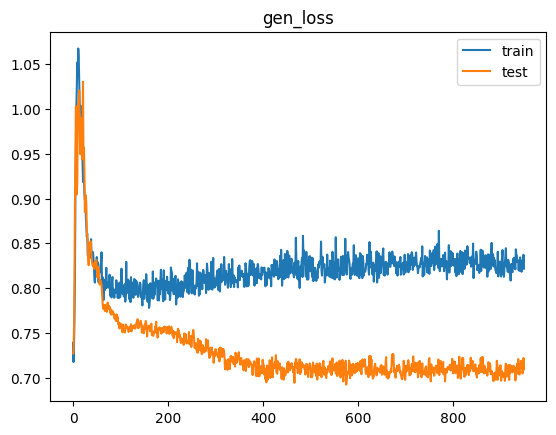

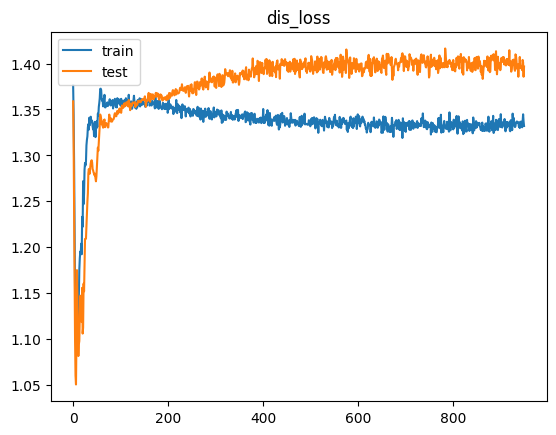

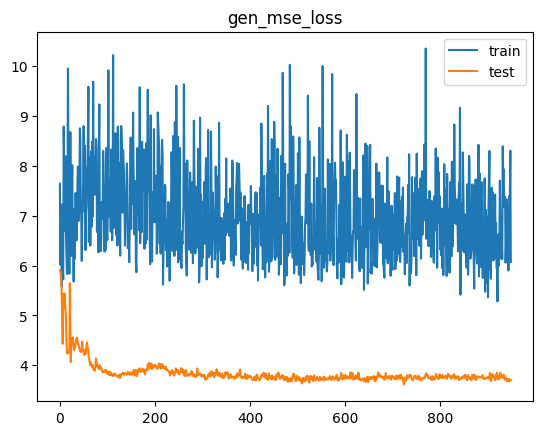

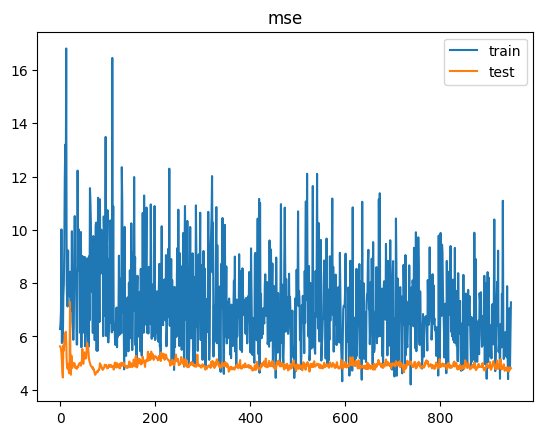

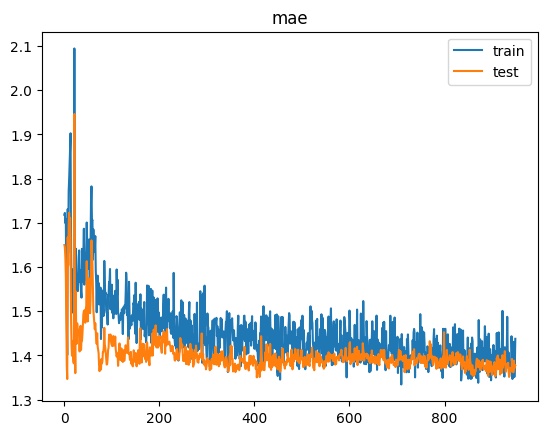

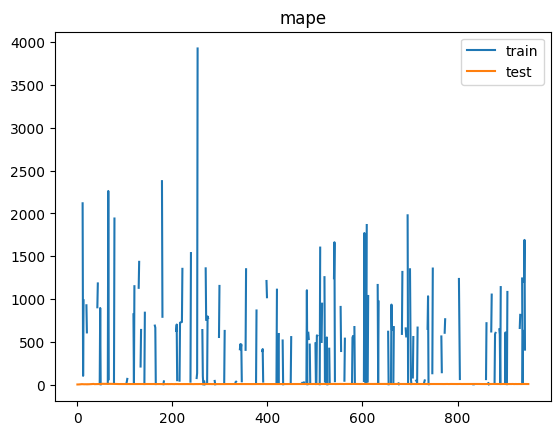

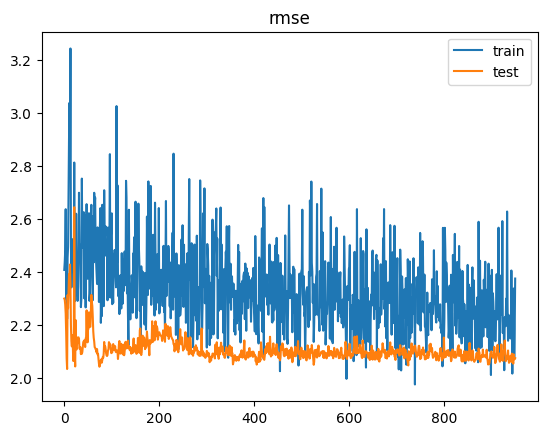

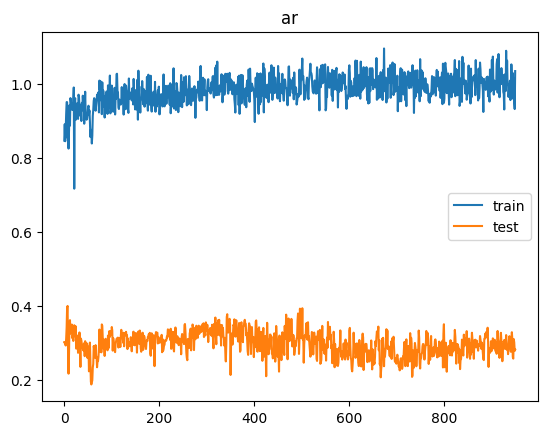

2/2 [==============================] - 1s 2ms/step


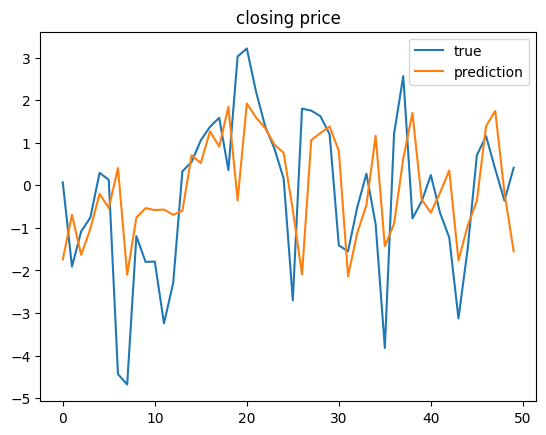

[MSE Baseline] train: 5.472210806026766  test: 4.16723565376744
Delta time with epochs = 950: 0:14:41.906989
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 20)             0         
                

Time for epoch 51 is 0.9020473957061768 sec Generator Loss: 0.8318306803703308,  Discriminator_loss: 1.363379716873169
Time for epoch 52 is 0.8943746089935303 sec Generator Loss: 0.8156241178512573,  Discriminator_loss: 1.357926368713379
Time for epoch 53 is 0.8994293212890625 sec Generator Loss: 0.8444987535476685,  Discriminator_loss: 1.354406714439392
Time for epoch 54 is 0.8922438621520996 sec Generator Loss: 0.8354927897453308,  Discriminator_loss: 1.3537830114364624
Time for epoch 55 is 0.8999896049499512 sec Generator Loss: 0.818266749382019,  Discriminator_loss: 1.355292558670044
Time for epoch 56 is 0.9071431159973145 sec Generator Loss: 0.827092707157135,  Discriminator_loss: 1.3527400493621826
Time for epoch 57 is 0.8954553604125977 sec Generator Loss: 0.8101969361305237,  Discriminator_loss: 1.3533921241760254
Time for epoch 58 is 0.8934915065765381 sec Generator Loss: 0.8203012943267822,  Discriminator_loss: 1.3466436862945557
Time for epoch 59 is 0.8895630836486816 sec Ge

Time for epoch 120 is 0.9005081653594971 sec Generator Loss: 0.8005072474479675,  Discriminator_loss: 1.3508332967758179
Time for epoch 121 is 0.9199554920196533 sec Generator Loss: 0.8002269268035889,  Discriminator_loss: 1.356974482536316
Time for epoch 122 is 0.9011363983154297 sec Generator Loss: 0.8099229335784912,  Discriminator_loss: 1.3563659191131592
Time for epoch 123 is 0.9023120403289795 sec Generator Loss: 0.8125516772270203,  Discriminator_loss: 1.3455214500427246
Time for epoch 124 is 0.9154844284057617 sec Generator Loss: 0.8012743592262268,  Discriminator_loss: 1.3514710664749146
Time for epoch 125 is 0.8958253860473633 sec Generator Loss: 0.8010256290435791,  Discriminator_loss: 1.3540103435516357
Time for epoch 126 is 0.9053983688354492 sec Generator Loss: 0.7924565672874451,  Discriminator_loss: 1.3522428274154663
Time for epoch 127 is 0.8987672328948975 sec Generator Loss: 0.7958945631980896,  Discriminator_loss: 1.34515380859375
Time for epoch 128 is 0.90740919113

Time for epoch 189 is 0.9103872776031494 sec Generator Loss: 0.7989635467529297,  Discriminator_loss: 1.3480439186096191
Time for epoch 190 is 0.912649393081665 sec Generator Loss: 0.7974833846092224,  Discriminator_loss: 1.3588975667953491
Time for epoch 191 is 0.9098818302154541 sec Generator Loss: 0.7909523844718933,  Discriminator_loss: 1.3610215187072754
Time for epoch 192 is 0.9087045192718506 sec Generator Loss: 0.790484607219696,  Discriminator_loss: 1.3564822673797607
Time for epoch 193 is 0.9046664237976074 sec Generator Loss: 0.8035420179367065,  Discriminator_loss: 1.3595876693725586
Time for epoch 194 is 0.9045062065124512 sec Generator Loss: 0.7865036725997925,  Discriminator_loss: 1.3550082445144653
Time for epoch 195 is 0.8959193229675293 sec Generator Loss: 0.7876730561256409,  Discriminator_loss: 1.357025384902954
Time for epoch 196 is 0.9334137439727783 sec Generator Loss: 0.7976295351982117,  Discriminator_loss: 1.360862135887146
Time for epoch 197 is 0.911288738250

Time for epoch 258 is 0.9612200260162354 sec Generator Loss: 0.7937366366386414,  Discriminator_loss: 1.35277259349823
Time for epoch 259 is 1.0808382034301758 sec Generator Loss: 0.7994168400764465,  Discriminator_loss: 1.3555350303649902
Time for epoch 260 is 0.9799692630767822 sec Generator Loss: 0.8004740476608276,  Discriminator_loss: 1.3509187698364258
Time for epoch 261 is 1.0296666622161865 sec Generator Loss: 0.8094032406806946,  Discriminator_loss: 1.351679801940918
Time for epoch 262 is 1.0755646228790283 sec Generator Loss: 0.8001547455787659,  Discriminator_loss: 1.3504019975662231
Time for epoch 263 is 1.0612213611602783 sec Generator Loss: 0.7949934005737305,  Discriminator_loss: 1.3531672954559326
Time for epoch 264 is 1.1088533401489258 sec Generator Loss: 0.7889291048049927,  Discriminator_loss: 1.3519655466079712
Time for epoch 265 is 0.9748396873474121 sec Generator Loss: 0.8145427107810974,  Discriminator_loss: 1.3489444255828857
Time for epoch 266 is 0.98563122749

Time for epoch 326 is 1.0020952224731445 sec Generator Loss: 0.7868852615356445,  Discriminator_loss: 1.3555500507354736
Time for epoch 327 is 0.9990711212158203 sec Generator Loss: 0.8175261616706848,  Discriminator_loss: 1.343883752822876
Time for epoch 328 is 1.0358061790466309 sec Generator Loss: 0.7950298190116882,  Discriminator_loss: 1.3512026071548462
Time for epoch 329 is 0.9978940486907959 sec Generator Loss: 0.8123600482940674,  Discriminator_loss: 1.3486701250076294
Time for epoch 330 is 1.042151689529419 sec Generator Loss: 0.8096343874931335,  Discriminator_loss: 1.3414487838745117
Time for epoch 331 is 1.0451979637145996 sec Generator Loss: 0.8033630847930908,  Discriminator_loss: 1.3404909372329712
Time for epoch 332 is 1.0243151187896729 sec Generator Loss: 0.8125481605529785,  Discriminator_loss: 1.3418998718261719
Time for epoch 333 is 0.9792580604553223 sec Generator Loss: 0.8088536262512207,  Discriminator_loss: 1.3438361883163452
Time for epoch 334 is 0.9848132133

Time for epoch 394 is 0.9791955947875977 sec Generator Loss: 0.8128211498260498,  Discriminator_loss: 1.3368721008300781
Time for epoch 395 is 0.9767305850982666 sec Generator Loss: 0.8260012865066528,  Discriminator_loss: 1.340453028678894
Time for epoch 396 is 0.9711740016937256 sec Generator Loss: 0.8117569088935852,  Discriminator_loss: 1.3402103185653687
Time for epoch 397 is 0.9599664211273193 sec Generator Loss: 0.831257164478302,  Discriminator_loss: 1.3369544744491577
Time for epoch 398 is 0.9975974559783936 sec Generator Loss: 0.8124384880065918,  Discriminator_loss: 1.3398162126541138
Time for epoch 399 is 0.996340274810791 sec Generator Loss: 0.8055731654167175,  Discriminator_loss: 1.33843195438385
Time for epoch 400 is 0.9815361499786377 sec Generator Loss: 0.8274444937705994,  Discriminator_loss: 1.3404251337051392
Time for epoch 401 is 1.2027528285980225 sec Generator Loss: 0.8207454085350037,  Discriminator_loss: 1.347721815109253
Time for epoch 402 is 1.00301241874694

Time for epoch 463 is 1.0172367095947266 sec Generator Loss: 0.8237894177436829,  Discriminator_loss: 1.3404321670532227
Time for epoch 464 is 1.016624927520752 sec Generator Loss: 0.820372998714447,  Discriminator_loss: 1.3464845418930054
Time for epoch 465 is 1.0580518245697021 sec Generator Loss: 0.8037261962890625,  Discriminator_loss: 1.3461713790893555
Time for epoch 466 is 0.9715852737426758 sec Generator Loss: 0.815384030342102,  Discriminator_loss: 1.3403819799423218
Time for epoch 467 is 1.0186119079589844 sec Generator Loss: 0.8305394649505615,  Discriminator_loss: 1.33395254611969
Time for epoch 468 is 0.9920089244842529 sec Generator Loss: 0.8267247080802917,  Discriminator_loss: 1.3362973928451538
Time for epoch 469 is 0.9803073406219482 sec Generator Loss: 0.854870080947876,  Discriminator_loss: 1.3363127708435059
Time for epoch 470 is 0.9997200965881348 sec Generator Loss: 0.827573299407959,  Discriminator_loss: 1.3447948694229126
Time for epoch 471 is 0.985358953475952

Time for epoch 531 is 0.9651713371276855 sec Generator Loss: 0.8081694841384888,  Discriminator_loss: 1.3357902765274048
Time for epoch 532 is 0.9850125312805176 sec Generator Loss: 0.8186336755752563,  Discriminator_loss: 1.3386284112930298
Time for epoch 533 is 0.9989545345306396 sec Generator Loss: 0.8140406012535095,  Discriminator_loss: 1.3383575677871704
Time for epoch 534 is 0.9947855472564697 sec Generator Loss: 0.8183473944664001,  Discriminator_loss: 1.3393456935882568
Time for epoch 535 is 0.9835159778594971 sec Generator Loss: 0.8238516449928284,  Discriminator_loss: 1.3402000665664673
Time for epoch 536 is 0.9716777801513672 sec Generator Loss: 0.8214628100395203,  Discriminator_loss: 1.3351523876190186
Time for epoch 537 is 0.9632506370544434 sec Generator Loss: 0.828632116317749,  Discriminator_loss: 1.3425310850143433
Time for epoch 538 is 0.9950718879699707 sec Generator Loss: 0.8192383646965027,  Discriminator_loss: 1.336566686630249
Time for epoch 539 is 0.9862186908

Time for epoch 600 is 1.0678820610046387 sec Generator Loss: 0.8214989900588989,  Discriminator_loss: 1.3356980085372925
Time for epoch 601 is 0.9857125282287598 sec Generator Loss: 0.8214831948280334,  Discriminator_loss: 1.3286261558532715
Time for epoch 602 is 0.9877943992614746 sec Generator Loss: 0.8108586072921753,  Discriminator_loss: 1.343906283378601
Time for epoch 603 is 0.97552490234375 sec Generator Loss: 0.8184540271759033,  Discriminator_loss: 1.3269422054290771
Time for epoch 604 is 0.9552669525146484 sec Generator Loss: 0.8285252451896667,  Discriminator_loss: 1.338496446609497
Time for epoch 605 is 0.9435722827911377 sec Generator Loss: 0.8322088718414307,  Discriminator_loss: 1.3329877853393555
Time for epoch 606 is 0.9434664249420166 sec Generator Loss: 0.8268887996673584,  Discriminator_loss: 1.335371494293213
Time for epoch 607 is 0.9314510822296143 sec Generator Loss: 0.8137456178665161,  Discriminator_loss: 1.3360118865966797
Time for epoch 608 is 0.9326488971710

Time for epoch 669 is 0.9753139019012451 sec Generator Loss: 0.8208523988723755,  Discriminator_loss: 1.3352469205856323
Time for epoch 670 is 0.9879968166351318 sec Generator Loss: 0.8145825862884521,  Discriminator_loss: 1.3414487838745117
Time for epoch 671 is 0.9768285751342773 sec Generator Loss: 0.8080121874809265,  Discriminator_loss: 1.3386598825454712
Time for epoch 672 is 0.9961912631988525 sec Generator Loss: 0.8147250413894653,  Discriminator_loss: 1.3405030965805054
Time for epoch 673 is 0.9859700202941895 sec Generator Loss: 0.8175234794616699,  Discriminator_loss: 1.3334685564041138
Time for epoch 674 is 1.0036141872406006 sec Generator Loss: 0.8187713623046875,  Discriminator_loss: 1.3403958082199097
Time for epoch 675 is 1.0213525295257568 sec Generator Loss: 0.8252543210983276,  Discriminator_loss: 1.3393490314483643
Time for epoch 676 is 1.0928940773010254 sec Generator Loss: 0.8195177912712097,  Discriminator_loss: 1.3388117551803589
Time for epoch 677 is 1.04070854

Time for epoch 737 is 0.9827485084533691 sec Generator Loss: 0.8117347955703735,  Discriminator_loss: 1.342165470123291
Time for epoch 738 is 0.9885451793670654 sec Generator Loss: 0.8177279829978943,  Discriminator_loss: 1.3378549814224243
Time for epoch 739 is 0.9962937831878662 sec Generator Loss: 0.8196471333503723,  Discriminator_loss: 1.3366894721984863
Time for epoch 740 is 0.9945051670074463 sec Generator Loss: 0.8153880834579468,  Discriminator_loss: 1.334894061088562
Time for epoch 741 is 1.0222065448760986 sec Generator Loss: 0.8222540020942688,  Discriminator_loss: 1.3426094055175781
Time for epoch 742 is 0.9369909763336182 sec Generator Loss: 0.8134215474128723,  Discriminator_loss: 1.3365205526351929
Time for epoch 743 is 1.1742088794708252 sec Generator Loss: 0.8140724897384644,  Discriminator_loss: 1.3328804969787598
Time for epoch 744 is 1.0026187896728516 sec Generator Loss: 0.8236766457557678,  Discriminator_loss: 1.3334838151931763
Time for epoch 745 is 0.9666354656

Time for epoch 806 is 1.0315213203430176 sec Generator Loss: 0.8135541081428528,  Discriminator_loss: 1.3380438089370728
Time for epoch 807 is 1.0160284042358398 sec Generator Loss: 0.8197273015975952,  Discriminator_loss: 1.3347792625427246
Time for epoch 808 is 0.9787092208862305 sec Generator Loss: 0.8401254415512085,  Discriminator_loss: 1.3304404020309448
Time for epoch 809 is 0.9920542240142822 sec Generator Loss: 0.8215210437774658,  Discriminator_loss: 1.3324971199035645
Time for epoch 810 is 0.9774603843688965 sec Generator Loss: 0.8166443705558777,  Discriminator_loss: 1.3400640487670898
Time for epoch 811 is 0.9837479591369629 sec Generator Loss: 0.8120221495628357,  Discriminator_loss: 1.3435916900634766
Time for epoch 812 is 0.9913091659545898 sec Generator Loss: 0.8488060832023621,  Discriminator_loss: 1.336500644683838
Time for epoch 813 is 0.9877526760101318 sec Generator Loss: 0.8206791281700134,  Discriminator_loss: 1.3454242944717407
Time for epoch 814 is 0.990809679

Time for epoch 874 is 1.0757427215576172 sec Generator Loss: 0.8144170641899109,  Discriminator_loss: 1.3473751544952393
Time for epoch 875 is 1.043367624282837 sec Generator Loss: 0.8242499828338623,  Discriminator_loss: 1.334085464477539
Time for epoch 876 is 1.03359055519104 sec Generator Loss: 0.83442223072052,  Discriminator_loss: 1.329970121383667
Time for epoch 877 is 1.1425797939300537 sec Generator Loss: 0.8202508687973022,  Discriminator_loss: 1.3330689668655396
Time for epoch 878 is 1.2764689922332764 sec Generator Loss: 0.8145255446434021,  Discriminator_loss: 1.3397356271743774
Time for epoch 879 is 1.2320830821990967 sec Generator Loss: 0.8254137635231018,  Discriminator_loss: 1.345403790473938
Time for epoch 880 is 1.0526478290557861 sec Generator Loss: 0.8347209095954895,  Discriminator_loss: 1.3340553045272827
Time for epoch 881 is 1.0215098857879639 sec Generator Loss: 0.8060033917427063,  Discriminator_loss: 1.3404405117034912
Time for epoch 882 is 1.008251667022705 

Time for epoch 943 is 0.9852581024169922 sec Generator Loss: 0.8272913098335266,  Discriminator_loss: 1.3416129350662231
Time for epoch 944 is 1.0213634967803955 sec Generator Loss: 0.814713716506958,  Discriminator_loss: 1.3421077728271484
Time for epoch 945 is 1.0024144649505615 sec Generator Loss: 0.8035339713096619,  Discriminator_loss: 1.339763879776001
Time for epoch 946 is 0.9961893558502197 sec Generator Loss: 0.8246588706970215,  Discriminator_loss: 1.3388797044754028
Time for epoch 947 is 1.0239803791046143 sec Generator Loss: 0.8188437223434448,  Discriminator_loss: 1.338334560394287
Time for epoch 948 is 0.9998123645782471 sec Generator Loss: 0.8148888945579529,  Discriminator_loss: 1.341025948524475
Time for epoch 949 is 1.0885834693908691 sec Generator Loss: 0.80927574634552,  Discriminator_loss: 1.3373812437057495
Time for epoch 950 is 0.9980671405792236 sec Generator Loss: 0.8145276308059692,  Discriminator_loss: 1.3407939672470093
Time for epoch 951 is 1.04589080810546

Time for epoch 1011 is 0.9880781173706055 sec Generator Loss: 0.8301523327827454,  Discriminator_loss: 1.3310152292251587
Time for epoch 1012 is 0.9842517375946045 sec Generator Loss: 0.812372624874115,  Discriminator_loss: 1.3397310972213745
Time for epoch 1013 is 0.9826838970184326 sec Generator Loss: 0.8101255893707275,  Discriminator_loss: 1.3456043004989624
Time for epoch 1014 is 1.0007925033569336 sec Generator Loss: 0.820711076259613,  Discriminator_loss: 1.3360705375671387
Time for epoch 1015 is 1.0458252429962158 sec Generator Loss: 0.8076794147491455,  Discriminator_loss: 1.3369165658950806
Time for epoch 1016 is 0.9948570728302002 sec Generator Loss: 0.8232672214508057,  Discriminator_loss: 1.332040548324585
Time for epoch 1017 is 0.9692342281341553 sec Generator Loss: 0.8325998187065125,  Discriminator_loss: 1.3374980688095093
Time for epoch 1018 is 1.0210402011871338 sec Generator Loss: 0.8246938586235046,  Discriminator_loss: 1.3370299339294434
Time for epoch 1019 is 1.03

Time for epoch 1079 is 0.9273176193237305 sec Generator Loss: 0.8178571462631226,  Discriminator_loss: 1.3492298126220703
Time for epoch 1080 is 0.9294028282165527 sec Generator Loss: 0.8182385563850403,  Discriminator_loss: 1.3366895914077759
Time for epoch 1081 is 0.9262702465057373 sec Generator Loss: 0.81358802318573,  Discriminator_loss: 1.3385505676269531
Time for epoch 1082 is 0.9566779136657715 sec Generator Loss: 0.8296611309051514,  Discriminator_loss: 1.3391108512878418
Time for epoch 1083 is 0.9671909809112549 sec Generator Loss: 0.8195971250534058,  Discriminator_loss: 1.3437275886535645
Time for epoch 1084 is 1.0121045112609863 sec Generator Loss: 0.8224908709526062,  Discriminator_loss: 1.3376426696777344
Time for epoch 1085 is 1.1298599243164062 sec Generator Loss: 0.8135569095611572,  Discriminator_loss: 1.3418464660644531
Time for epoch 1086 is 1.0000524520874023 sec Generator Loss: 0.8163143992424011,  Discriminator_loss: 1.3470571041107178
Time for epoch 1087 is 0.9

Time for epoch 1147 is 0.969832181930542 sec Generator Loss: 0.8244355320930481,  Discriminator_loss: 1.3473798036575317
Time for epoch 1148 is 0.9941122531890869 sec Generator Loss: 0.8199790120124817,  Discriminator_loss: 1.339651346206665
Time for epoch 1149 is 0.9926693439483643 sec Generator Loss: 0.8069533705711365,  Discriminator_loss: 1.345851182937622
Time for epoch 1150 is 0.9863548278808594 sec Generator Loss: 0.8212613463401794,  Discriminator_loss: 1.3395850658416748
Time for epoch 1151 is 0.9968547821044922 sec Generator Loss: 0.8198807239532471,  Discriminator_loss: 1.349905252456665
Time for epoch 1152 is 0.9790318012237549 sec Generator Loss: 0.8268548846244812,  Discriminator_loss: 1.342014193534851
Time for epoch 1153 is 1.0045843124389648 sec Generator Loss: 0.815557599067688,  Discriminator_loss: 1.3442317247390747
Time for epoch 1154 is 1.008819580078125 sec Generator Loss: 0.8310006856918335,  Discriminator_loss: 1.3488059043884277
Time for epoch 1155 is 0.994937

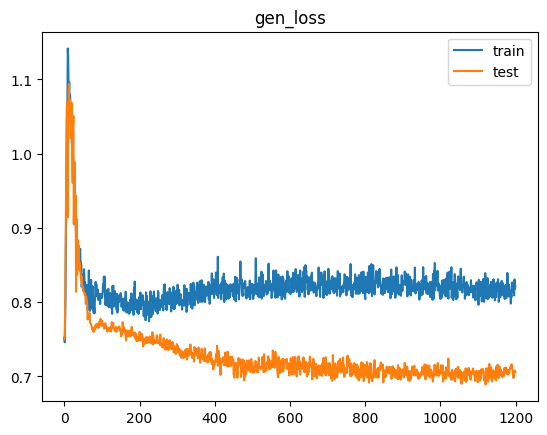

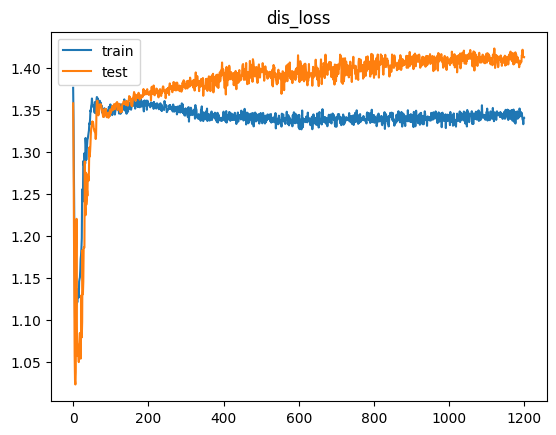

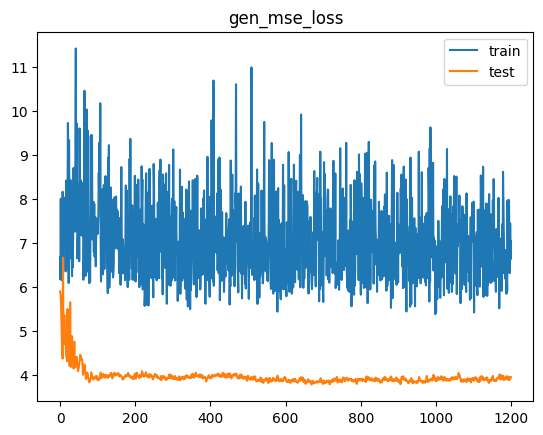

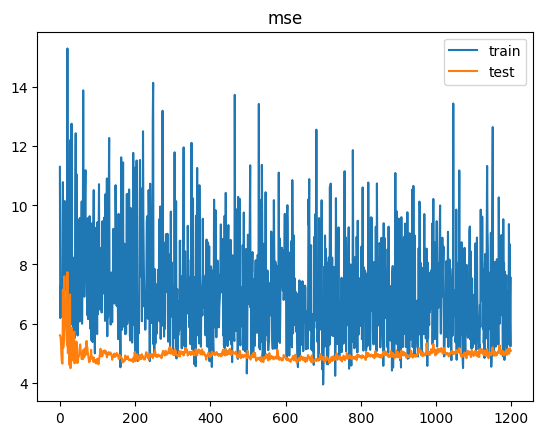

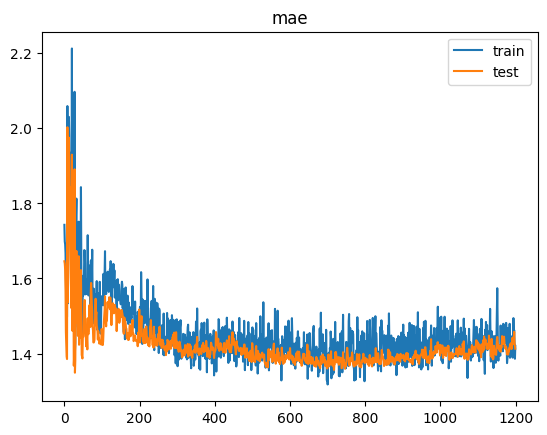

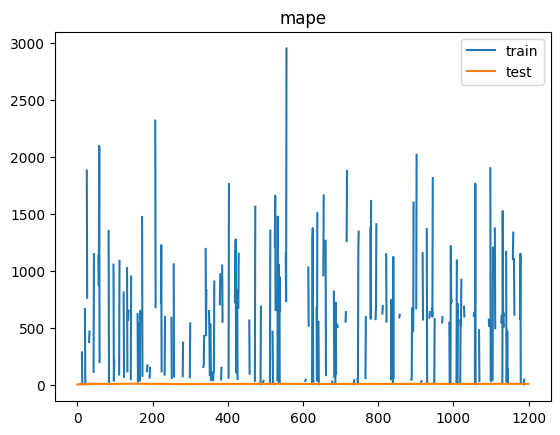

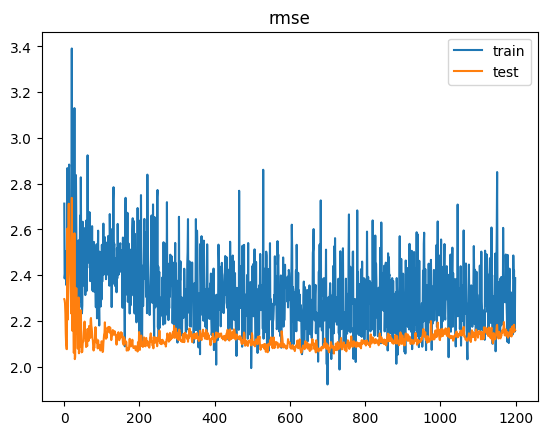

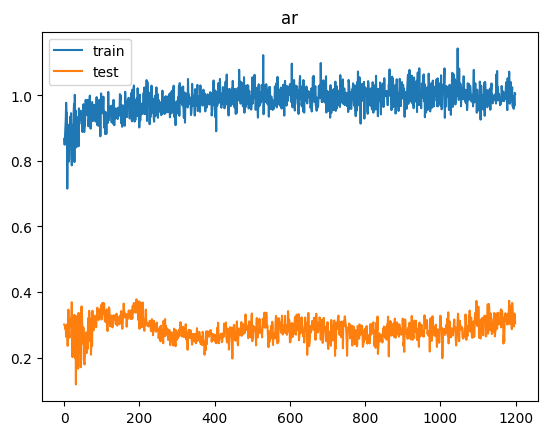

2/2 [==============================] - 1s 3ms/step


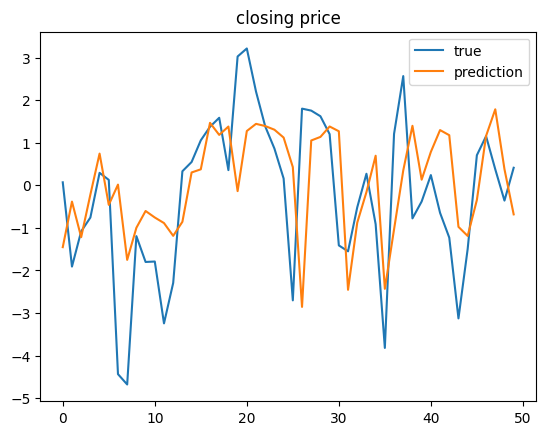

[MSE Baseline] train: 12.44991354311617  test: 4.16723565376744
Delta time with epochs = 1200: 0:20:25.761316
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_10 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 20)             0         
               

Time for epoch 51 is 0.8397407531738281 sec Generator Loss: 0.8253636956214905,  Discriminator_loss: 1.3455450534820557
Time for epoch 52 is 0.8632333278656006 sec Generator Loss: 0.8228514194488525,  Discriminator_loss: 1.3392512798309326
Time for epoch 53 is 0.8494763374328613 sec Generator Loss: 0.8424022197723389,  Discriminator_loss: 1.3423926830291748
Time for epoch 54 is 0.8515255451202393 sec Generator Loss: 0.8369371294975281,  Discriminator_loss: 1.3449673652648926
Time for epoch 55 is 0.8328166007995605 sec Generator Loss: 0.8219245672225952,  Discriminator_loss: 1.3439428806304932
Time for epoch 56 is 0.8394918441772461 sec Generator Loss: 0.8615033030509949,  Discriminator_loss: 1.3434252738952637
Time for epoch 57 is 0.9327967166900635 sec Generator Loss: 0.8233247399330139,  Discriminator_loss: 1.3444308042526245
Time for epoch 58 is 0.8710639476776123 sec Generator Loss: 0.8193350434303284,  Discriminator_loss: 1.3462978601455688
Time for epoch 59 is 0.8649129867553711 

Time for epoch 120 is 1.0192375183105469 sec Generator Loss: 0.7987759113311768,  Discriminator_loss: 1.353247046470642
Time for epoch 121 is 0.9918656349182129 sec Generator Loss: 0.7991163730621338,  Discriminator_loss: 1.3577873706817627
Time for epoch 122 is 1.0215280055999756 sec Generator Loss: 0.8138865232467651,  Discriminator_loss: 1.3516484498977661
Time for epoch 123 is 0.9818670749664307 sec Generator Loss: 0.8103958368301392,  Discriminator_loss: 1.3517694473266602
Time for epoch 124 is 0.9891865253448486 sec Generator Loss: 0.8239537477493286,  Discriminator_loss: 1.3526073694229126
Time for epoch 125 is 0.9457833766937256 sec Generator Loss: 0.793350338935852,  Discriminator_loss: 1.3559061288833618
Time for epoch 126 is 0.9321331977844238 sec Generator Loss: 0.7973226308822632,  Discriminator_loss: 1.3553849458694458
Time for epoch 127 is 0.9280054569244385 sec Generator Loss: 0.7973359823226929,  Discriminator_loss: 1.351636290550232
Time for epoch 128 is 0.92522835731

Time for epoch 189 is 1.0797450542449951 sec Generator Loss: 0.803635835647583,  Discriminator_loss: 1.3573720455169678
Time for epoch 190 is 1.0523393154144287 sec Generator Loss: 0.7911867499351501,  Discriminator_loss: 1.360764980316162
Time for epoch 191 is 1.027543544769287 sec Generator Loss: 0.7788030505180359,  Discriminator_loss: 1.3602732419967651
Time for epoch 192 is 1.1239228248596191 sec Generator Loss: 0.7963649034500122,  Discriminator_loss: 1.3600807189941406
Time for epoch 193 is 1.0899512767791748 sec Generator Loss: 0.8097651600837708,  Discriminator_loss: 1.3576973676681519
Time for epoch 194 is 1.0450725555419922 sec Generator Loss: 0.7912613153457642,  Discriminator_loss: 1.3605570793151855
Time for epoch 195 is 0.9857218265533447 sec Generator Loss: 0.7957718968391418,  Discriminator_loss: 1.3675031661987305
Time for epoch 196 is 1.0078270435333252 sec Generator Loss: 0.777822732925415,  Discriminator_loss: 1.362123727798462
Time for epoch 197 is 0.9982824325561

Time for epoch 258 is 0.94437575340271 sec Generator Loss: 0.7840595245361328,  Discriminator_loss: 1.359613299369812
Time for epoch 259 is 0.9281971454620361 sec Generator Loss: 0.7999227046966553,  Discriminator_loss: 1.3537020683288574
Time for epoch 260 is 0.9285275936126709 sec Generator Loss: 0.7960037589073181,  Discriminator_loss: 1.3602120876312256
Time for epoch 261 is 1.0157804489135742 sec Generator Loss: 0.8098386526107788,  Discriminator_loss: 1.3512742519378662
Time for epoch 262 is 0.9732403755187988 sec Generator Loss: 0.7916841506958008,  Discriminator_loss: 1.361533761024475
Time for epoch 263 is 0.945530891418457 sec Generator Loss: 0.8144454956054688,  Discriminator_loss: 1.3656402826309204
Time for epoch 264 is 0.9643549919128418 sec Generator Loss: 0.7977581024169922,  Discriminator_loss: 1.36631441116333
Time for epoch 265 is 0.9468386173248291 sec Generator Loss: 0.782856822013855,  Discriminator_loss: 1.360987901687622
Time for epoch 266 is 1.0616087913513184 

Time for epoch 327 is 0.9378702640533447 sec Generator Loss: 0.7983701229095459,  Discriminator_loss: 1.3591192960739136
Time for epoch 328 is 0.9497585296630859 sec Generator Loss: 0.837382435798645,  Discriminator_loss: 1.3482967615127563
Time for epoch 329 is 0.9641153812408447 sec Generator Loss: 0.8187879323959351,  Discriminator_loss: 1.3516287803649902
Time for epoch 330 is 1.0414659976959229 sec Generator Loss: 0.8008976578712463,  Discriminator_loss: 1.3534469604492188
Time for epoch 331 is 0.9795138835906982 sec Generator Loss: 0.7923020124435425,  Discriminator_loss: 1.3564287424087524
Time for epoch 332 is 1.1467583179473877 sec Generator Loss: 0.805489718914032,  Discriminator_loss: 1.348239541053772
Time for epoch 333 is 1.131251335144043 sec Generator Loss: 0.8070811629295349,  Discriminator_loss: 1.3516422510147095
Time for epoch 334 is 0.9984173774719238 sec Generator Loss: 0.8183380365371704,  Discriminator_loss: 1.348343849182129
Time for epoch 335 is 0.9825596809387

Time for epoch 395 is 1.0192835330963135 sec Generator Loss: 0.83624666929245,  Discriminator_loss: 1.3432068824768066
Time for epoch 396 is 1.018347978591919 sec Generator Loss: 0.8048003911972046,  Discriminator_loss: 1.343634009361267
Time for epoch 397 is 1.0180189609527588 sec Generator Loss: 0.798824667930603,  Discriminator_loss: 1.344075322151184
Time for epoch 398 is 1.0382437705993652 sec Generator Loss: 0.8000353574752808,  Discriminator_loss: 1.3422632217407227
Time for epoch 399 is 1.0740382671356201 sec Generator Loss: 0.8003025054931641,  Discriminator_loss: 1.350994348526001
Time for epoch 400 is 1.0558650493621826 sec Generator Loss: 0.8116279244422913,  Discriminator_loss: 1.3327281475067139
Time for epoch 401 is 1.0128655433654785 sec Generator Loss: 0.8122654557228088,  Discriminator_loss: 1.343841552734375
Time for epoch 402 is 1.0315008163452148 sec Generator Loss: 0.8097338676452637,  Discriminator_loss: 1.3453742265701294
Time for epoch 403 is 1.0434417724609375

Time for epoch 464 is 1.0607318878173828 sec Generator Loss: 0.836169958114624,  Discriminator_loss: 1.3388937711715698
Time for epoch 465 is 0.9455876350402832 sec Generator Loss: 0.8221017122268677,  Discriminator_loss: 1.3401765823364258
Time for epoch 466 is 0.9451837539672852 sec Generator Loss: 0.8234537839889526,  Discriminator_loss: 1.329162359237671
Time for epoch 467 is 0.956279993057251 sec Generator Loss: 0.8215105533599854,  Discriminator_loss: 1.3316097259521484
Time for epoch 468 is 0.9565103054046631 sec Generator Loss: 0.8413955569267273,  Discriminator_loss: 1.3325989246368408
Time for epoch 469 is 0.9602687358856201 sec Generator Loss: 0.8249788284301758,  Discriminator_loss: 1.3450558185577393
Time for epoch 470 is 0.9605019092559814 sec Generator Loss: 0.8112598061561584,  Discriminator_loss: 1.3372559547424316
Time for epoch 471 is 0.9395411014556885 sec Generator Loss: 0.8222637176513672,  Discriminator_loss: 1.3357126712799072
Time for epoch 472 is 0.94872212409

Time for epoch 532 is 0.9471735954284668 sec Generator Loss: 0.8307859897613525,  Discriminator_loss: 1.3352606296539307
Time for epoch 533 is 0.9343311786651611 sec Generator Loss: 0.8230606913566589,  Discriminator_loss: 1.3325536251068115
Time for epoch 534 is 0.9523563385009766 sec Generator Loss: 0.8201679587364197,  Discriminator_loss: 1.3345658779144287
Time for epoch 535 is 1.0384023189544678 sec Generator Loss: 0.8306578993797302,  Discriminator_loss: 1.3326245546340942
Time for epoch 536 is 1.159104347229004 sec Generator Loss: 0.8256068825721741,  Discriminator_loss: 1.3319345712661743
Time for epoch 537 is 0.9717621803283691 sec Generator Loss: 0.8155489563941956,  Discriminator_loss: 1.330548644065857
Time for epoch 538 is 0.9960513114929199 sec Generator Loss: 0.8243484497070312,  Discriminator_loss: 1.3358534574508667
Time for epoch 539 is 0.9940097332000732 sec Generator Loss: 0.832474410533905,  Discriminator_loss: 1.337092399597168
Time for epoch 540 is 1.110188961029

Time for epoch 600 is 0.9454286098480225 sec Generator Loss: 0.8202831745147705,  Discriminator_loss: 1.3329945802688599
Time for epoch 601 is 0.9441938400268555 sec Generator Loss: 0.8385958671569824,  Discriminator_loss: 1.3224985599517822
Time for epoch 602 is 0.9915781021118164 sec Generator Loss: 0.8254964351654053,  Discriminator_loss: 1.3292409181594849
Time for epoch 603 is 1.0322763919830322 sec Generator Loss: 0.834079921245575,  Discriminator_loss: 1.3284802436828613
Time for epoch 604 is 0.9680063724517822 sec Generator Loss: 0.8132303953170776,  Discriminator_loss: 1.3372273445129395
Time for epoch 605 is 0.9712643623352051 sec Generator Loss: 0.8335786461830139,  Discriminator_loss: 1.329569697380066
Time for epoch 606 is 0.9592106342315674 sec Generator Loss: 0.8229362964630127,  Discriminator_loss: 1.3346222639083862
Time for epoch 607 is 1.024338960647583 sec Generator Loss: 0.8427029252052307,  Discriminator_loss: 1.326771855354309
Time for epoch 608 is 1.186742544174

Time for epoch 668 is 0.9719316959381104 sec Generator Loss: 0.8465107083320618,  Discriminator_loss: 1.3333979845046997
Time for epoch 669 is 0.9378781318664551 sec Generator Loss: 0.8385841846466064,  Discriminator_loss: 1.3330577611923218
Time for epoch 670 is 0.9402711391448975 sec Generator Loss: 0.8273871541023254,  Discriminator_loss: 1.3341970443725586
Time for epoch 671 is 0.955498218536377 sec Generator Loss: 0.8239129185676575,  Discriminator_loss: 1.338553547859192
Time for epoch 672 is 0.9470090866088867 sec Generator Loss: 0.834685206413269,  Discriminator_loss: 1.3299896717071533
Time for epoch 673 is 0.9792015552520752 sec Generator Loss: 0.8390108346939087,  Discriminator_loss: 1.3358213901519775
Time for epoch 674 is 0.946234941482544 sec Generator Loss: 0.8247078657150269,  Discriminator_loss: 1.3302336931228638
Time for epoch 675 is 0.9410109519958496 sec Generator Loss: 0.8218322396278381,  Discriminator_loss: 1.3332998752593994
Time for epoch 676 is 0.965274095535

Time for epoch 737 is 1.064805507659912 sec Generator Loss: 0.8300886154174805,  Discriminator_loss: 1.3349088430404663
Time for epoch 738 is 0.9910194873809814 sec Generator Loss: 0.82136070728302,  Discriminator_loss: 1.333964228630066
Time for epoch 739 is 0.9692840576171875 sec Generator Loss: 0.8361493945121765,  Discriminator_loss: 1.3323211669921875
Time for epoch 740 is 1.0449843406677246 sec Generator Loss: 0.8144831657409668,  Discriminator_loss: 1.3401997089385986
Time for epoch 741 is 0.9806497097015381 sec Generator Loss: 0.8102861046791077,  Discriminator_loss: 1.3418865203857422
Time for epoch 742 is 0.9708507061004639 sec Generator Loss: 0.8172987699508667,  Discriminator_loss: 1.3313654661178589
Time for epoch 743 is 0.972609281539917 sec Generator Loss: 0.823780357837677,  Discriminator_loss: 1.330634355545044
Time for epoch 744 is 0.9944281578063965 sec Generator Loss: 0.8251156806945801,  Discriminator_loss: 1.3349603414535522
Time for epoch 745 is 1.040999174118042

Time for epoch 806 is 1.017812728881836 sec Generator Loss: 0.8177011013031006,  Discriminator_loss: 1.3410648107528687
Time for epoch 807 is 0.9674553871154785 sec Generator Loss: 0.8153390884399414,  Discriminator_loss: 1.3304083347320557
Time for epoch 808 is 0.9602887630462646 sec Generator Loss: 0.8413923382759094,  Discriminator_loss: 1.3318467140197754
Time for epoch 809 is 0.9860625267028809 sec Generator Loss: 0.8064542412757874,  Discriminator_loss: 1.3403422832489014
Time for epoch 810 is 0.9701550006866455 sec Generator Loss: 0.827377200126648,  Discriminator_loss: 1.3297103643417358
Time for epoch 811 is 0.9880738258361816 sec Generator Loss: 0.834825336933136,  Discriminator_loss: 1.3294185400009155
Time for epoch 812 is 1.000528335571289 sec Generator Loss: 0.8167657256126404,  Discriminator_loss: 1.3368724584579468
Time for epoch 813 is 0.9616076946258545 sec Generator Loss: 0.8196091651916504,  Discriminator_loss: 1.3373432159423828
Time for epoch 814 is 0.955693006515

Time for epoch 875 is 0.9780652523040771 sec Generator Loss: 0.8168144226074219,  Discriminator_loss: 1.3378570079803467
Time for epoch 876 is 1.0339272022247314 sec Generator Loss: 0.8353289365768433,  Discriminator_loss: 1.3375664949417114
Time for epoch 877 is 0.9771037101745605 sec Generator Loss: 0.8372886180877686,  Discriminator_loss: 1.3360289335250854
Time for epoch 878 is 0.981069803237915 sec Generator Loss: 0.8279951214790344,  Discriminator_loss: 1.3303933143615723
Time for epoch 879 is 0.964557409286499 sec Generator Loss: 0.8317006826400757,  Discriminator_loss: 1.3364238739013672
Time for epoch 880 is 0.9648640155792236 sec Generator Loss: 0.8142899870872498,  Discriminator_loss: 1.3424569368362427
Time for epoch 881 is 1.0392074584960938 sec Generator Loss: 0.8390179872512817,  Discriminator_loss: 1.3339146375656128
Time for epoch 882 is 0.9966905117034912 sec Generator Loss: 0.8183408975601196,  Discriminator_loss: 1.338047742843628
Time for epoch 883 is 0.98134231567

Time for epoch 943 is 0.9817962646484375 sec Generator Loss: 0.8198429942131042,  Discriminator_loss: 1.339131236076355
Time for epoch 944 is 0.9699392318725586 sec Generator Loss: 0.8231487274169922,  Discriminator_loss: 1.3401094675064087
Time for epoch 945 is 0.9603760242462158 sec Generator Loss: 0.8157088160514832,  Discriminator_loss: 1.333882451057434
Time for epoch 946 is 0.9994635581970215 sec Generator Loss: 0.8082727193832397,  Discriminator_loss: 1.3455140590667725
Time for epoch 947 is 0.990769624710083 sec Generator Loss: 0.824664294719696,  Discriminator_loss: 1.33512544631958
Time for epoch 948 is 0.971717357635498 sec Generator Loss: 0.8252561092376709,  Discriminator_loss: 1.3378937244415283
Time for epoch 949 is 0.9799575805664062 sec Generator Loss: 0.8351658582687378,  Discriminator_loss: 1.337051272392273
Time for epoch 950 is 0.9801425933837891 sec Generator Loss: 0.826201319694519,  Discriminator_loss: 1.3397399187088013
Time for epoch 951 is 0.9798722267150879 

Time for epoch 1012 is 0.9760918617248535 sec Generator Loss: 0.8330044746398926,  Discriminator_loss: 1.3396233320236206
Time for epoch 1013 is 0.964724063873291 sec Generator Loss: 0.8208939433097839,  Discriminator_loss: 1.3476064205169678
Time for epoch 1014 is 1.0101017951965332 sec Generator Loss: 0.8247764706611633,  Discriminator_loss: 1.3361709117889404
Time for epoch 1015 is 1.0398695468902588 sec Generator Loss: 0.8044515252113342,  Discriminator_loss: 1.3491135835647583
Time for epoch 1016 is 0.9870305061340332 sec Generator Loss: 0.816399335861206,  Discriminator_loss: 1.3461743593215942
Time for epoch 1017 is 0.9804413318634033 sec Generator Loss: 0.8312427997589111,  Discriminator_loss: 1.3397636413574219
Time for epoch 1018 is 0.9672706127166748 sec Generator Loss: 0.8192861080169678,  Discriminator_loss: 1.3393898010253906
Time for epoch 1019 is 0.9666893482208252 sec Generator Loss: 0.8180804252624512,  Discriminator_loss: 1.3394278287887573
Time for epoch 1020 is 0.9

Time for epoch 1080 is 0.9947657585144043 sec Generator Loss: 0.8293042778968811,  Discriminator_loss: 1.3337275981903076
Time for epoch 1081 is 0.9755024909973145 sec Generator Loss: 0.8149022459983826,  Discriminator_loss: 1.340012550354004
Time for epoch 1082 is 0.9828591346740723 sec Generator Loss: 0.824763298034668,  Discriminator_loss: 1.3357146978378296
Time for epoch 1083 is 0.9878871440887451 sec Generator Loss: 0.816592276096344,  Discriminator_loss: 1.3422852754592896
Time for epoch 1084 is 1.0199406147003174 sec Generator Loss: 0.8247042298316956,  Discriminator_loss: 1.3330084085464478
Time for epoch 1085 is 1.0442461967468262 sec Generator Loss: 0.8129842877388,  Discriminator_loss: 1.3415158987045288
Time for epoch 1086 is 1.0403027534484863 sec Generator Loss: 0.8275009989738464,  Discriminator_loss: 1.3361210823059082
Time for epoch 1087 is 1.0252685546875 sec Generator Loss: 0.8409866690635681,  Discriminator_loss: 1.3328157663345337
Time for epoch 1088 is 1.03795075

Time for epoch 1148 is 1.0186433792114258 sec Generator Loss: 0.8109952211380005,  Discriminator_loss: 1.3439897298812866
Time for epoch 1149 is 1.0718891620635986 sec Generator Loss: 0.8207108378410339,  Discriminator_loss: 1.3354750871658325
Time for epoch 1150 is 1.072371482849121 sec Generator Loss: 0.8145179748535156,  Discriminator_loss: 1.338492512702942
Time for epoch 1151 is 1.0297367572784424 sec Generator Loss: 0.8302175998687744,  Discriminator_loss: 1.3368993997573853
Time for epoch 1152 is 1.019733190536499 sec Generator Loss: 0.8146137595176697,  Discriminator_loss: 1.33358895778656
Time for epoch 1153 is 1.0255813598632812 sec Generator Loss: 0.8120246529579163,  Discriminator_loss: 1.3447316884994507
Time for epoch 1154 is 1.0583515167236328 sec Generator Loss: 0.8138970732688904,  Discriminator_loss: 1.3390390872955322
Time for epoch 1155 is 1.0485148429870605 sec Generator Loss: 0.8199521899223328,  Discriminator_loss: 1.3346796035766602
Time for epoch 1156 is 1.0633

Time for epoch 1216 is 0.974534273147583 sec Generator Loss: 0.8152322769165039,  Discriminator_loss: 1.3432819843292236
Time for epoch 1217 is 0.9782571792602539 sec Generator Loss: 0.822291374206543,  Discriminator_loss: 1.3400154113769531
Time for epoch 1218 is 1.0027570724487305 sec Generator Loss: 0.8197476863861084,  Discriminator_loss: 1.3435205221176147
Time for epoch 1219 is 0.9921088218688965 sec Generator Loss: 0.8257114291191101,  Discriminator_loss: 1.3377629518508911
Time for epoch 1220 is 0.9704527854919434 sec Generator Loss: 0.8107764720916748,  Discriminator_loss: 1.340342402458191
Time for epoch 1221 is 0.9709854125976562 sec Generator Loss: 0.822555661201477,  Discriminator_loss: 1.3371585607528687
Time for epoch 1222 is 0.9553561210632324 sec Generator Loss: 0.8213738799095154,  Discriminator_loss: 1.3419955968856812
Time for epoch 1223 is 0.9841432571411133 sec Generator Loss: 0.8117060661315918,  Discriminator_loss: 1.3415433168411255
Time for epoch 1224 is 1.013

Time for epoch 1284 is 0.9897711277008057 sec Generator Loss: 0.8094573020935059,  Discriminator_loss: 1.3470399379730225
Time for epoch 1285 is 0.9746139049530029 sec Generator Loss: 0.814655601978302,  Discriminator_loss: 1.3305586576461792
Time for epoch 1286 is 0.9682002067565918 sec Generator Loss: 0.8212689757347107,  Discriminator_loss: 1.3481228351593018
Time for epoch 1287 is 0.9695262908935547 sec Generator Loss: 0.8049299716949463,  Discriminator_loss: 1.3464343547821045
Time for epoch 1288 is 0.991157054901123 sec Generator Loss: 0.833315908908844,  Discriminator_loss: 1.3452283143997192
Time for epoch 1289 is 0.9915726184844971 sec Generator Loss: 0.8128059506416321,  Discriminator_loss: 1.3422198295593262
Time for epoch 1290 is 0.9770779609680176 sec Generator Loss: 0.8163841366767883,  Discriminator_loss: 1.3411049842834473
Time for epoch 1291 is 0.9769189357757568 sec Generator Loss: 0.8145401477813721,  Discriminator_loss: 1.3447500467300415
Time for epoch 1292 is 0.99

Time for epoch 1352 is 1.0481841564178467 sec Generator Loss: 0.8159880042076111,  Discriminator_loss: 1.3358798027038574
Time for epoch 1353 is 1.0461602210998535 sec Generator Loss: 0.8155850768089294,  Discriminator_loss: 1.3372087478637695
Time for epoch 1354 is 1.0581190586090088 sec Generator Loss: 0.8178601861000061,  Discriminator_loss: 1.3424031734466553
Time for epoch 1355 is 1.0536987781524658 sec Generator Loss: 0.8247257471084595,  Discriminator_loss: 1.3360905647277832
Time for epoch 1356 is 1.0668461322784424 sec Generator Loss: 0.8194777965545654,  Discriminator_loss: 1.336189866065979
Time for epoch 1357 is 1.0706632137298584 sec Generator Loss: 0.8235341906547546,  Discriminator_loss: 1.3453127145767212
Time for epoch 1358 is 1.0402188301086426 sec Generator Loss: 0.8201286196708679,  Discriminator_loss: 1.3484044075012207
Time for epoch 1359 is 1.0344085693359375 sec Generator Loss: 0.8160063028335571,  Discriminator_loss: 1.3485019207000732
Time for epoch 1360 is 1.

Time for epoch 1420 is 1.0044257640838623 sec Generator Loss: 0.8162550926208496,  Discriminator_loss: 1.3385732173919678
Time for epoch 1421 is 1.0040242671966553 sec Generator Loss: 0.8253623247146606,  Discriminator_loss: 1.340806245803833
Time for epoch 1422 is 1.0294320583343506 sec Generator Loss: 0.805864155292511,  Discriminator_loss: 1.3442246913909912
Time for epoch 1423 is 1.000126600265503 sec Generator Loss: 0.8074833750724792,  Discriminator_loss: 1.3385478258132935
Time for epoch 1424 is 1.0025217533111572 sec Generator Loss: 0.8029921650886536,  Discriminator_loss: 1.3521802425384521
Time for epoch 1425 is 0.9901003837585449 sec Generator Loss: 0.8162322640419006,  Discriminator_loss: 1.3353540897369385
Time for epoch 1426 is 0.9886083602905273 sec Generator Loss: 0.8271568417549133,  Discriminator_loss: 1.333114504814148
Time for epoch 1427 is 1.0210955142974854 sec Generator Loss: 0.8158288598060608,  Discriminator_loss: 1.3465046882629395
Time for epoch 1428 is 1.013

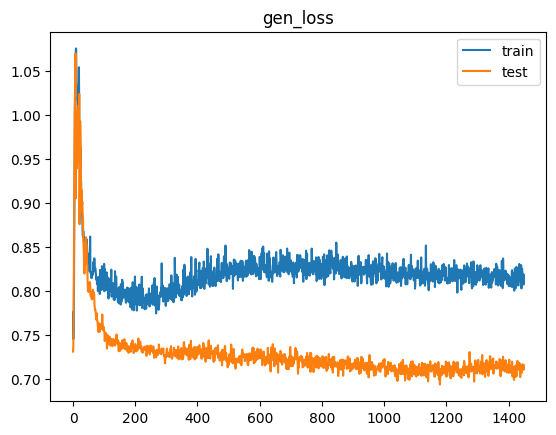

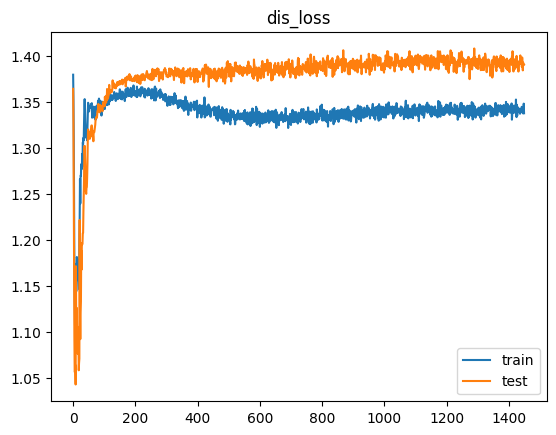

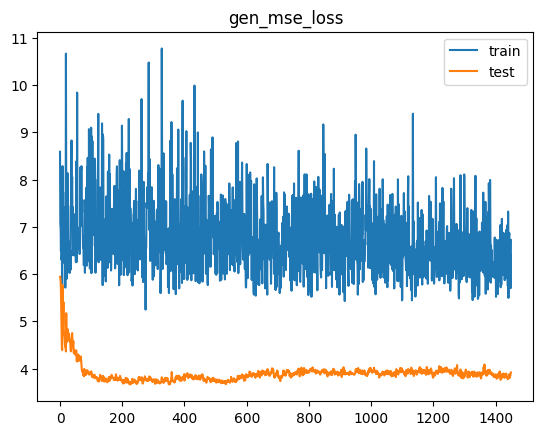

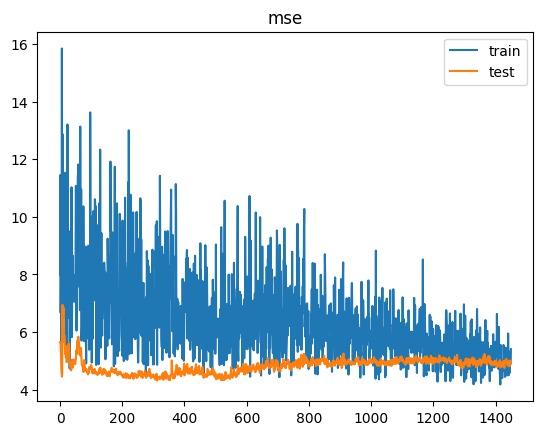

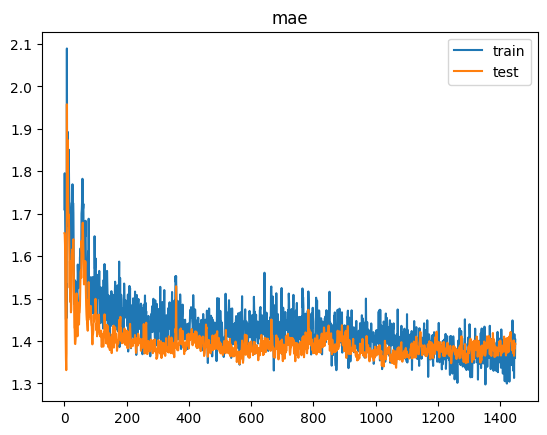

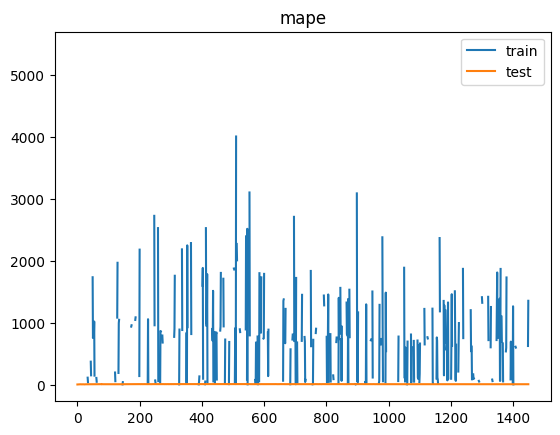

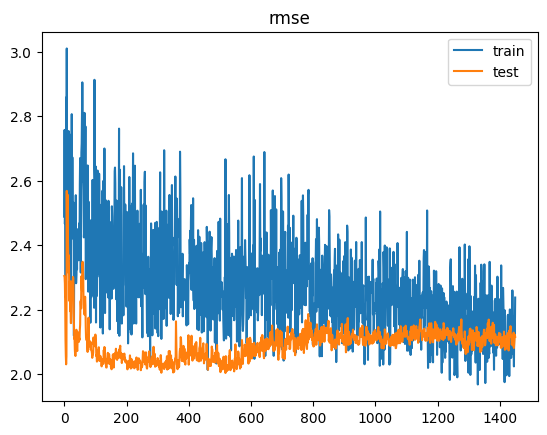

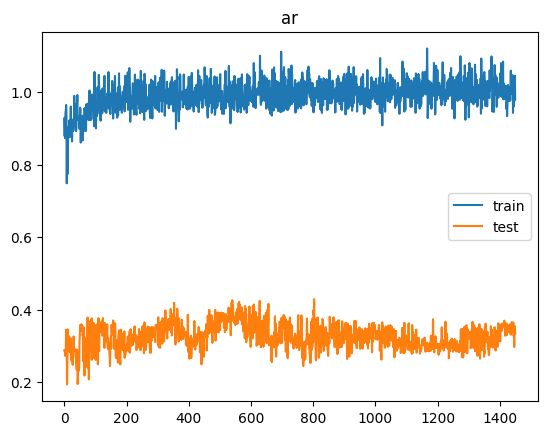

2/2 [==============================] - 1s 4ms/step


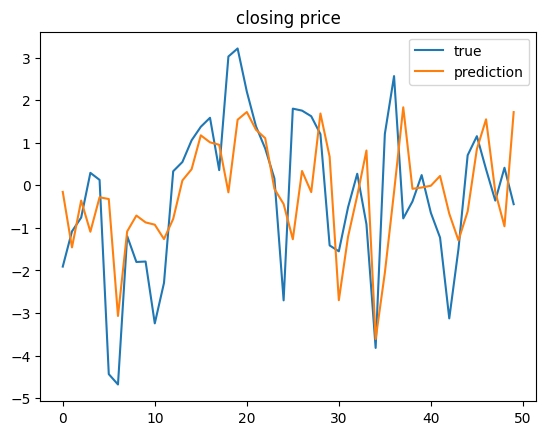

[MSE Baseline] train: 10.637876552355385  test: 4.18451216814071
Delta time with epochs = 1450: 0:24:25.321519
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_12 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 52 is 0.9725189208984375 sec Generator Loss: 0.7849762439727783,  Discriminator_loss: 1.3650391101837158
Time for epoch 53 is 0.9716122150421143 sec Generator Loss: 0.7932932376861572,  Discriminator_loss: 1.364485740661621
Time for epoch 54 is 0.958500862121582 sec Generator Loss: 0.7905685305595398,  Discriminator_loss: 1.368874192237854
Time for epoch 55 is 0.9563171863555908 sec Generator Loss: 0.7862668037414551,  Discriminator_loss: 1.3693361282348633
Time for epoch 56 is 0.959036111831665 sec Generator Loss: 0.7816839218139648,  Discriminator_loss: 1.3690584897994995
Time for epoch 57 is 0.9708802700042725 sec Generator Loss: 0.7813183665275574,  Discriminator_loss: 1.3682583570480347
Time for epoch 58 is 0.9861660003662109 sec Generator Loss: 0.8073874711990356,  Discriminator_loss: 1.3676774501800537
Time for epoch 59 is 0.9614017009735107 sec Generator Loss: 0.7978594303131104,  Discriminator_loss: 1.3611488342285156
Time for epoch 60 is 0.9630513191223145 sec 

Time for epoch 121 is 0.9700477123260498 sec Generator Loss: 0.7930293083190918,  Discriminator_loss: 1.3614453077316284
Time for epoch 122 is 1.0085406303405762 sec Generator Loss: 0.791253924369812,  Discriminator_loss: 1.3702304363250732
Time for epoch 123 is 0.966559648513794 sec Generator Loss: 0.7994970083236694,  Discriminator_loss: 1.365156888961792
Time for epoch 124 is 0.9772570133209229 sec Generator Loss: 0.774827778339386,  Discriminator_loss: 1.367741584777832
Time for epoch 125 is 0.971015453338623 sec Generator Loss: 0.7887231707572937,  Discriminator_loss: 1.3659807443618774
Time for epoch 126 is 0.9730699062347412 sec Generator Loss: 0.7780157327651978,  Discriminator_loss: 1.3642280101776123
Time for epoch 127 is 0.9694063663482666 sec Generator Loss: 0.7735981941223145,  Discriminator_loss: 1.3619829416275024
Time for epoch 128 is 0.9682109355926514 sec Generator Loss: 0.7868804335594177,  Discriminator_loss: 1.362517237663269
Time for epoch 129 is 0.969818830490112

Time for epoch 190 is 0.9825615882873535 sec Generator Loss: 0.7832202911376953,  Discriminator_loss: 1.3690992593765259
Time for epoch 191 is 0.9623904228210449 sec Generator Loss: 0.7843190431594849,  Discriminator_loss: 1.364457368850708
Time for epoch 192 is 0.956754207611084 sec Generator Loss: 0.7734188437461853,  Discriminator_loss: 1.3671954870224
Time for epoch 193 is 0.9812779426574707 sec Generator Loss: 0.778337836265564,  Discriminator_loss: 1.3670005798339844
Time for epoch 194 is 0.9389526844024658 sec Generator Loss: 0.7809342741966248,  Discriminator_loss: 1.3652559518814087
Time for epoch 195 is 0.9785373210906982 sec Generator Loss: 0.7861028909683228,  Discriminator_loss: 1.3630417585372925
Time for epoch 196 is 0.972055196762085 sec Generator Loss: 0.7745965719223022,  Discriminator_loss: 1.3698630332946777
Time for epoch 197 is 0.9559342861175537 sec Generator Loss: 0.7954155206680298,  Discriminator_loss: 1.363682746887207
Time for epoch 198 is 0.9655289649963379

Time for epoch 259 is 1.0349094867706299 sec Generator Loss: 0.7866226434707642,  Discriminator_loss: 1.3664966821670532
Time for epoch 260 is 1.0619077682495117 sec Generator Loss: 0.7950557470321655,  Discriminator_loss: 1.361268401145935
Time for epoch 261 is 1.1299402713775635 sec Generator Loss: 0.7789666652679443,  Discriminator_loss: 1.3624351024627686
Time for epoch 262 is 1.0829832553863525 sec Generator Loss: 0.7933242917060852,  Discriminator_loss: 1.3611253499984741
Time for epoch 263 is 1.095391035079956 sec Generator Loss: 0.7867570519447327,  Discriminator_loss: 1.363876223564148
Time for epoch 264 is 1.0570454597473145 sec Generator Loss: 0.7819563150405884,  Discriminator_loss: 1.3598392009735107
Time for epoch 265 is 1.0673444271087646 sec Generator Loss: 0.7688478827476501,  Discriminator_loss: 1.3653861284255981
Time for epoch 266 is 1.0652689933776855 sec Generator Loss: 0.7833389639854431,  Discriminator_loss: 1.3601219654083252
Time for epoch 267 is 1.09249019622

Time for epoch 328 is 1.0781543254852295 sec Generator Loss: 0.7782943844795227,  Discriminator_loss: 1.3585010766983032
Time for epoch 329 is 1.06278395652771 sec Generator Loss: 0.79933100938797,  Discriminator_loss: 1.354655385017395
Time for epoch 330 is 1.0419650077819824 sec Generator Loss: 0.7897219657897949,  Discriminator_loss: 1.3507323265075684
Time for epoch 331 is 1.054356575012207 sec Generator Loss: 0.794430136680603,  Discriminator_loss: 1.359190583229065
Time for epoch 332 is 1.0842974185943604 sec Generator Loss: 0.7874820232391357,  Discriminator_loss: 1.3529748916625977
Time for epoch 333 is 1.044844150543213 sec Generator Loss: 0.809235692024231,  Discriminator_loss: 1.3578932285308838
Time for epoch 334 is 1.0925064086914062 sec Generator Loss: 0.7925027012825012,  Discriminator_loss: 1.3670868873596191
Time for epoch 335 is 1.1229710578918457 sec Generator Loss: 0.7805393934249878,  Discriminator_loss: 1.3568105697631836
Time for epoch 336 is 1.0753600597381592 s

Time for epoch 397 is 1.0398204326629639 sec Generator Loss: 0.8034846186637878,  Discriminator_loss: 1.3541734218597412
Time for epoch 398 is 1.049518346786499 sec Generator Loss: 0.8013474941253662,  Discriminator_loss: 1.3504213094711304
Time for epoch 399 is 0.9975771903991699 sec Generator Loss: 0.7996677756309509,  Discriminator_loss: 1.3545864820480347
Time for epoch 400 is 0.9914813041687012 sec Generator Loss: 0.7943522930145264,  Discriminator_loss: 1.3472827672958374
Time for epoch 401 is 1.0039563179016113 sec Generator Loss: 0.7982463836669922,  Discriminator_loss: 1.3539916276931763
Time for epoch 402 is 1.0343043804168701 sec Generator Loss: 0.8025286197662354,  Discriminator_loss: 1.3502509593963623
Time for epoch 403 is 0.9810793399810791 sec Generator Loss: 0.8106791377067566,  Discriminator_loss: 1.3541251420974731
Time for epoch 404 is 1.0043504238128662 sec Generator Loss: 0.7994987964630127,  Discriminator_loss: 1.3503559827804565
Time for epoch 405 is 0.997482061

Time for epoch 465 is 0.9787306785583496 sec Generator Loss: 0.8025228977203369,  Discriminator_loss: 1.3445135354995728
Time for epoch 466 is 0.9757387638092041 sec Generator Loss: 0.7985956072807312,  Discriminator_loss: 1.346354365348816
Time for epoch 467 is 0.9817044734954834 sec Generator Loss: 0.813237726688385,  Discriminator_loss: 1.3477998971939087
Time for epoch 468 is 0.9810075759887695 sec Generator Loss: 0.791892945766449,  Discriminator_loss: 1.3522945642471313
Time for epoch 469 is 1.002598762512207 sec Generator Loss: 0.8033815026283264,  Discriminator_loss: 1.3550275564193726
Time for epoch 470 is 0.9715721607208252 sec Generator Loss: 0.800747811794281,  Discriminator_loss: 1.3472065925598145
Time for epoch 471 is 0.9775164127349854 sec Generator Loss: 0.8083817958831787,  Discriminator_loss: 1.3527668714523315
Time for epoch 472 is 0.9678769111633301 sec Generator Loss: 0.7925819754600525,  Discriminator_loss: 1.3509818315505981
Time for epoch 473 is 0.9834129810333

Time for epoch 534 is 0.9921543598175049 sec Generator Loss: 0.7967844009399414,  Discriminator_loss: 1.3476632833480835
Time for epoch 535 is 0.9770236015319824 sec Generator Loss: 0.8040748834609985,  Discriminator_loss: 1.348164677619934
Time for epoch 536 is 0.9897987842559814 sec Generator Loss: 0.798000156879425,  Discriminator_loss: 1.3491308689117432
Time for epoch 537 is 0.9704008102416992 sec Generator Loss: 0.7962760329246521,  Discriminator_loss: 1.3515634536743164
Time for epoch 538 is 0.9836390018463135 sec Generator Loss: 0.8022658228874207,  Discriminator_loss: 1.3500070571899414
Time for epoch 539 is 1.003005027770996 sec Generator Loss: 0.8140913844108582,  Discriminator_loss: 1.344607949256897
Time for epoch 540 is 0.9821832180023193 sec Generator Loss: 0.7967748045921326,  Discriminator_loss: 1.3538539409637451
Time for epoch 541 is 0.9815244674682617 sec Generator Loss: 0.7975557446479797,  Discriminator_loss: 1.3496652841567993
Time for epoch 542 is 0.988097190856

Time for epoch 603 is 1.009796380996704 sec Generator Loss: 0.789754331111908,  Discriminator_loss: 1.3484097719192505
Time for epoch 604 is 0.9871618747711182 sec Generator Loss: 0.7993647456169128,  Discriminator_loss: 1.351204752922058
Time for epoch 605 is 1.0114367008209229 sec Generator Loss: 0.7941997647285461,  Discriminator_loss: 1.3443773984909058
Time for epoch 606 is 0.9863791465759277 sec Generator Loss: 0.7964615225791931,  Discriminator_loss: 1.3490267992019653
Time for epoch 607 is 1.0183990001678467 sec Generator Loss: 0.8083078861236572,  Discriminator_loss: 1.3463729619979858
Time for epoch 608 is 0.9819614887237549 sec Generator Loss: 0.8016674518585205,  Discriminator_loss: 1.347159504890442
Time for epoch 609 is 0.9741408824920654 sec Generator Loss: 0.8051509857177734,  Discriminator_loss: 1.3564202785491943
Time for epoch 610 is 1.000401258468628 sec Generator Loss: 0.8091495037078857,  Discriminator_loss: 1.347606897354126
Time for epoch 611 is 1.01001095771789

Time for epoch 672 is 1.012183427810669 sec Generator Loss: 0.7898568511009216,  Discriminator_loss: 1.3544483184814453
Time for epoch 673 is 1.0056099891662598 sec Generator Loss: 0.8009560704231262,  Discriminator_loss: 1.3523601293563843
Time for epoch 674 is 1.0270452499389648 sec Generator Loss: 0.7849404811859131,  Discriminator_loss: 1.3618206977844238
Time for epoch 675 is 0.9880862236022949 sec Generator Loss: 0.7973592281341553,  Discriminator_loss: 1.358120083808899
Time for epoch 676 is 1.0048222541809082 sec Generator Loss: 0.8000415563583374,  Discriminator_loss: 1.3510372638702393
Time for epoch 677 is 0.9798369407653809 sec Generator Loss: 0.7931041121482849,  Discriminator_loss: 1.3569003343582153
Time for epoch 678 is 0.9938778877258301 sec Generator Loss: 0.8037675619125366,  Discriminator_loss: 1.3486301898956299
Time for epoch 679 is 0.9852967262268066 sec Generator Loss: 0.7962906956672668,  Discriminator_loss: 1.3480597734451294
Time for epoch 680 is 1.0112876892

Time for epoch 740 is 1.005786657333374 sec Generator Loss: 0.804472029209137,  Discriminator_loss: 1.3511149883270264
Time for epoch 741 is 1.0073490142822266 sec Generator Loss: 0.7917329668998718,  Discriminator_loss: 1.3604580163955688
Time for epoch 742 is 1.0143699645996094 sec Generator Loss: 0.7990408539772034,  Discriminator_loss: 1.3551620244979858
Time for epoch 743 is 1.003967523574829 sec Generator Loss: 0.8037018179893494,  Discriminator_loss: 1.3472235202789307
Time for epoch 744 is 1.0192286968231201 sec Generator Loss: 0.7986593246459961,  Discriminator_loss: 1.3431310653686523
Time for epoch 745 is 1.004469871520996 sec Generator Loss: 0.8058682680130005,  Discriminator_loss: 1.3582998514175415
Time for epoch 746 is 1.0156476497650146 sec Generator Loss: 0.798622727394104,  Discriminator_loss: 1.356948733329773
Time for epoch 747 is 1.0118322372436523 sec Generator Loss: 0.811733067035675,  Discriminator_loss: 1.3522329330444336
Time for epoch 748 is 1.055882692337036

Time for epoch 809 is 1.0871057510375977 sec Generator Loss: 0.8083864450454712,  Discriminator_loss: 1.3506377935409546
Time for epoch 810 is 1.053910255432129 sec Generator Loss: 0.7999894618988037,  Discriminator_loss: 1.3554975986480713
Time for epoch 811 is 1.1365103721618652 sec Generator Loss: 0.8049067854881287,  Discriminator_loss: 1.354536771774292
Time for epoch 812 is 1.084263801574707 sec Generator Loss: 0.7967841029167175,  Discriminator_loss: 1.354627013206482
Time for epoch 813 is 1.0515005588531494 sec Generator Loss: 0.8007131814956665,  Discriminator_loss: 1.3477100133895874
Time for epoch 814 is 1.0613703727722168 sec Generator Loss: 0.8049501180648804,  Discriminator_loss: 1.3528088331222534
Time for epoch 815 is 1.0117452144622803 sec Generator Loss: 0.7942283749580383,  Discriminator_loss: 1.3494335412979126
Time for epoch 816 is 1.0295813083648682 sec Generator Loss: 0.8030661940574646,  Discriminator_loss: 1.3509067296981812
Time for epoch 817 is 0.992172241210

Time for epoch 878 is 1.1072192192077637 sec Generator Loss: 0.8125993013381958,  Discriminator_loss: 1.350746512413025
Time for epoch 879 is 1.1280457973480225 sec Generator Loss: 0.7962038516998291,  Discriminator_loss: 1.3507109880447388
Time for epoch 880 is 1.178727626800537 sec Generator Loss: 0.8093042969703674,  Discriminator_loss: 1.3501778841018677
Time for epoch 881 is 1.4300758838653564 sec Generator Loss: 0.7955411672592163,  Discriminator_loss: 1.350501298904419
Time for epoch 882 is 1.2734146118164062 sec Generator Loss: 0.8016558885574341,  Discriminator_loss: 1.3508057594299316
Time for epoch 883 is 1.1722402572631836 sec Generator Loss: 0.8061861991882324,  Discriminator_loss: 1.3573805093765259
Time for epoch 884 is 1.1370351314544678 sec Generator Loss: 0.8213629126548767,  Discriminator_loss: 1.3465375900268555
Time for epoch 885 is 1.2562129497528076 sec Generator Loss: 0.8101149797439575,  Discriminator_loss: 1.354576826095581
Time for epoch 886 is 1.441604375839

Time for epoch 947 is 1.1680099964141846 sec Generator Loss: 0.7930423617362976,  Discriminator_loss: 1.3574271202087402
Time for epoch 948 is 1.109544038772583 sec Generator Loss: 0.7957897186279297,  Discriminator_loss: 1.3534117937088013
Time for epoch 949 is 1.1288363933563232 sec Generator Loss: 0.7873095273971558,  Discriminator_loss: 1.3568288087844849
Time for epoch 950 is 1.08003568649292 sec Generator Loss: 0.787088930606842,  Discriminator_loss: 1.3515985012054443
Time for epoch 951 is 1.1005783081054688 sec Generator Loss: 0.8105176091194153,  Discriminator_loss: 1.3549747467041016
Time for epoch 952 is 1.2064099311828613 sec Generator Loss: 0.7900987863540649,  Discriminator_loss: 1.349588394165039
Time for epoch 953 is 1.187333583831787 sec Generator Loss: 0.7937237024307251,  Discriminator_loss: 1.349760890007019
Time for epoch 954 is 1.0968892574310303 sec Generator Loss: 0.8029823899269104,  Discriminator_loss: 1.353834867477417
Time for epoch 955 is 1.1395130157470703

Time for epoch 1015 is 1.1765594482421875 sec Generator Loss: 0.7863551378250122,  Discriminator_loss: 1.354953408241272
Time for epoch 1016 is 1.3382880687713623 sec Generator Loss: 0.8087067604064941,  Discriminator_loss: 1.3467429876327515
Time for epoch 1017 is 1.3834664821624756 sec Generator Loss: 0.8034442067146301,  Discriminator_loss: 1.3509647846221924
Time for epoch 1018 is 1.6480796337127686 sec Generator Loss: 0.805270791053772,  Discriminator_loss: 1.3553571701049805
Time for epoch 1019 is 1.962921142578125 sec Generator Loss: 0.8043981194496155,  Discriminator_loss: 1.3536813259124756
Time for epoch 1020 is 1.6829257011413574 sec Generator Loss: 0.8115260601043701,  Discriminator_loss: 1.3487732410430908
Time for epoch 1021 is 1.3373134136199951 sec Generator Loss: 0.7942191362380981,  Discriminator_loss: 1.3574680089950562
Time for epoch 1022 is 1.1869337558746338 sec Generator Loss: 0.7831577658653259,  Discriminator_loss: 1.3603390455245972
Time for epoch 1023 is 1.22

Time for epoch 1083 is 1.1177489757537842 sec Generator Loss: 0.791242778301239,  Discriminator_loss: 1.3522521257400513
Time for epoch 1084 is 1.1268315315246582 sec Generator Loss: 0.8075587153434753,  Discriminator_loss: 1.3561798334121704
Time for epoch 1085 is 1.1208820343017578 sec Generator Loss: 0.796286404132843,  Discriminator_loss: 1.348681926727295
Time for epoch 1086 is 1.0938043594360352 sec Generator Loss: 0.8043192028999329,  Discriminator_loss: 1.3520537614822388
Time for epoch 1087 is 1.2140214443206787 sec Generator Loss: 0.7932078242301941,  Discriminator_loss: 1.352840781211853
Time for epoch 1088 is 1.163745641708374 sec Generator Loss: 0.7817556858062744,  Discriminator_loss: 1.362127423286438
Time for epoch 1089 is 1.1698439121246338 sec Generator Loss: 0.796725332736969,  Discriminator_loss: 1.351590633392334
Time for epoch 1090 is 1.1282341480255127 sec Generator Loss: 0.808628499507904,  Discriminator_loss: 1.3536231517791748
Time for epoch 1091 is 1.14266252

Time for epoch 1151 is 1.2904183864593506 sec Generator Loss: 0.811576783657074,  Discriminator_loss: 1.349130392074585
Time for epoch 1152 is 1.389784336090088 sec Generator Loss: 0.8012287616729736,  Discriminator_loss: 1.3551418781280518
Time for epoch 1153 is 1.2614672183990479 sec Generator Loss: 0.7883785367012024,  Discriminator_loss: 1.3533120155334473
Time for epoch 1154 is 1.4883718490600586 sec Generator Loss: 0.7989388704299927,  Discriminator_loss: 1.3530473709106445
Time for epoch 1155 is 1.2657749652862549 sec Generator Loss: 0.7890335917472839,  Discriminator_loss: 1.3579908609390259
Time for epoch 1156 is 1.2927508354187012 sec Generator Loss: 0.8141581416130066,  Discriminator_loss: 1.351336121559143
Time for epoch 1157 is 1.1314234733581543 sec Generator Loss: 0.8017958998680115,  Discriminator_loss: 1.348382830619812
Time for epoch 1158 is 1.2963178157806396 sec Generator Loss: 0.8009400963783264,  Discriminator_loss: 1.3447574377059937
Time for epoch 1159 is 1.5761

Time for epoch 1219 is 1.1033663749694824 sec Generator Loss: 0.8013492226600647,  Discriminator_loss: 1.3510321378707886
Time for epoch 1220 is 1.121267557144165 sec Generator Loss: 0.79795902967453,  Discriminator_loss: 1.3550992012023926
Time for epoch 1221 is 1.0798280239105225 sec Generator Loss: 0.8045525550842285,  Discriminator_loss: 1.3523166179656982
Time for epoch 1222 is 1.2047269344329834 sec Generator Loss: 0.802688717842102,  Discriminator_loss: 1.3483119010925293
Time for epoch 1223 is 1.2005369663238525 sec Generator Loss: 0.8046615719795227,  Discriminator_loss: 1.3535218238830566
Time for epoch 1224 is 1.1198992729187012 sec Generator Loss: 0.8047779202461243,  Discriminator_loss: 1.3517282009124756
Time for epoch 1225 is 1.0908448696136475 sec Generator Loss: 0.8040837049484253,  Discriminator_loss: 1.3503241539001465
Time for epoch 1226 is 1.0794804096221924 sec Generator Loss: 0.79526287317276,  Discriminator_loss: 1.3559759855270386
Time for epoch 1227 is 1.18068

Time for epoch 1287 is 1.1435894966125488 sec Generator Loss: 0.8021387457847595,  Discriminator_loss: 1.3540794849395752
Time for epoch 1288 is 1.3021574020385742 sec Generator Loss: 0.802605926990509,  Discriminator_loss: 1.3530322313308716
Time for epoch 1289 is 1.2048547267913818 sec Generator Loss: 0.805711030960083,  Discriminator_loss: 1.348254680633545
Time for epoch 1290 is 1.2815773487091064 sec Generator Loss: 0.7960338592529297,  Discriminator_loss: 1.355466604232788
Time for epoch 1291 is 1.2068274021148682 sec Generator Loss: 0.8006005883216858,  Discriminator_loss: 1.350420355796814
Time for epoch 1292 is 1.2007994651794434 sec Generator Loss: 0.8014925122261047,  Discriminator_loss: 1.348137617111206
Time for epoch 1293 is 1.3884036540985107 sec Generator Loss: 0.7996586561203003,  Discriminator_loss: 1.3460804224014282
Time for epoch 1294 is 1.3908395767211914 sec Generator Loss: 0.800249457359314,  Discriminator_loss: 1.354791283607483
Time for epoch 1295 is 1.1250531

Time for epoch 1355 is 1.3876173496246338 sec Generator Loss: 0.7919124960899353,  Discriminator_loss: 1.3546534776687622
Time for epoch 1356 is 1.2367401123046875 sec Generator Loss: 0.807401716709137,  Discriminator_loss: 1.3544539213180542
Time for epoch 1357 is 1.2834360599517822 sec Generator Loss: 0.7974157929420471,  Discriminator_loss: 1.3560717105865479
Time for epoch 1358 is 1.1232707500457764 sec Generator Loss: 0.8007152676582336,  Discriminator_loss: 1.351316213607788
Time for epoch 1359 is 1.2341587543487549 sec Generator Loss: 0.7866724133491516,  Discriminator_loss: 1.3562452793121338
Time for epoch 1360 is 1.3218379020690918 sec Generator Loss: 0.8013027906417847,  Discriminator_loss: 1.3541147708892822
Time for epoch 1361 is 1.1741859912872314 sec Generator Loss: 0.8092941641807556,  Discriminator_loss: 1.3524260520935059
Time for epoch 1362 is 1.239617109298706 sec Generator Loss: 0.7976514101028442,  Discriminator_loss: 1.3536193370819092
Time for epoch 1363 is 1.28

Time for epoch 1423 is 1.1222786903381348 sec Generator Loss: 0.7950007319450378,  Discriminator_loss: 1.3559774160385132
Time for epoch 1424 is 1.0851023197174072 sec Generator Loss: 0.7975807189941406,  Discriminator_loss: 1.3507007360458374
Time for epoch 1425 is 1.1303272247314453 sec Generator Loss: 0.8060925006866455,  Discriminator_loss: 1.355420470237732
Time for epoch 1426 is 1.169015645980835 sec Generator Loss: 0.7948612570762634,  Discriminator_loss: 1.3596080541610718
Time for epoch 1427 is 1.1227843761444092 sec Generator Loss: 0.7956891655921936,  Discriminator_loss: 1.3551595211029053
Time for epoch 1428 is 1.0864827632904053 sec Generator Loss: 0.8045333623886108,  Discriminator_loss: 1.3454893827438354
Time for epoch 1429 is 1.1522257328033447 sec Generator Loss: 0.7970573306083679,  Discriminator_loss: 1.3474587202072144
Time for epoch 1430 is 1.1548969745635986 sec Generator Loss: 0.8098616003990173,  Discriminator_loss: 1.348863959312439
Time for epoch 1431 is 1.14

Time for epoch 1491 is 1.1297805309295654 sec Generator Loss: 0.8002411127090454,  Discriminator_loss: 1.3472745418548584
Time for epoch 1492 is 1.205167293548584 sec Generator Loss: 0.8127409815788269,  Discriminator_loss: 1.3471603393554688
Time for epoch 1493 is 1.1923565864562988 sec Generator Loss: 0.7999178767204285,  Discriminator_loss: 1.352346658706665
Time for epoch 1494 is 1.0925872325897217 sec Generator Loss: 0.7962595224380493,  Discriminator_loss: 1.3511896133422852
Time for epoch 1495 is 1.3015995025634766 sec Generator Loss: 0.7918637990951538,  Discriminator_loss: 1.359674096107483
Time for epoch 1496 is 1.2064099311828613 sec Generator Loss: 0.7969436645507812,  Discriminator_loss: 1.3532899618148804
Time for epoch 1497 is 1.112518548965454 sec Generator Loss: 0.7937061190605164,  Discriminator_loss: 1.3519682884216309
Time for epoch 1498 is 1.2582969665527344 sec Generator Loss: 0.7953921556472778,  Discriminator_loss: 1.350632905960083
Time for epoch 1499 is 1.1672

Time for epoch 1559 is 1.2337241172790527 sec Generator Loss: 0.8012893199920654,  Discriminator_loss: 1.3479759693145752
Time for epoch 1560 is 1.2440848350524902 sec Generator Loss: 0.7897457480430603,  Discriminator_loss: 1.3557389974594116
Time for epoch 1561 is 1.358569860458374 sec Generator Loss: 0.7911295294761658,  Discriminator_loss: 1.353222370147705
Time for epoch 1562 is 1.2416706085205078 sec Generator Loss: 0.8018567562103271,  Discriminator_loss: 1.3495558500289917
Time for epoch 1563 is 1.1993129253387451 sec Generator Loss: 0.8032029867172241,  Discriminator_loss: 1.353278398513794
Time for epoch 1564 is 1.7797837257385254 sec Generator Loss: 0.7915589213371277,  Discriminator_loss: 1.3564379215240479
Time for epoch 1565 is 1.2568554878234863 sec Generator Loss: 0.8028630614280701,  Discriminator_loss: 1.3583401441574097
Time for epoch 1566 is 1.248784065246582 sec Generator Loss: 0.7951697707176208,  Discriminator_loss: 1.3556259870529175
Time for epoch 1567 is 1.231

Time for epoch 1627 is 1.1303961277008057 sec Generator Loss: 0.7936488389968872,  Discriminator_loss: 1.353782057762146
Time for epoch 1628 is 1.1751961708068848 sec Generator Loss: 0.7888784408569336,  Discriminator_loss: 1.357094168663025
Time for epoch 1629 is 1.131568193435669 sec Generator Loss: 0.7973664402961731,  Discriminator_loss: 1.350066900253296
Time for epoch 1630 is 1.1166110038757324 sec Generator Loss: 0.7912648916244507,  Discriminator_loss: 1.3596349954605103
Time for epoch 1631 is 1.314295768737793 sec Generator Loss: 0.7964837551116943,  Discriminator_loss: 1.3531970977783203
Time for epoch 1632 is 1.2435832023620605 sec Generator Loss: 0.7952038645744324,  Discriminator_loss: 1.3587671518325806
Time for epoch 1633 is 1.1636314392089844 sec Generator Loss: 0.7903154492378235,  Discriminator_loss: 1.3568922281265259
Time for epoch 1634 is 1.2826833724975586 sec Generator Loss: 0.800039529800415,  Discriminator_loss: 1.3498814105987549
Time for epoch 1635 is 1.23822

Time for epoch 1695 is 1.1803865432739258 sec Generator Loss: 0.7907018065452576,  Discriminator_loss: 1.3575936555862427
Time for epoch 1696 is 1.2923004627227783 sec Generator Loss: 0.7927577495574951,  Discriminator_loss: 1.3554999828338623
Time for epoch 1697 is 1.3023006916046143 sec Generator Loss: 0.8010401129722595,  Discriminator_loss: 1.3521239757537842
Time for epoch 1698 is 1.2073752880096436 sec Generator Loss: 0.8022153377532959,  Discriminator_loss: 1.3518038988113403
Time for epoch 1699 is 1.1216168403625488 sec Generator Loss: 0.8082643747329712,  Discriminator_loss: 1.354738473892212
Time for epoch 1700 is 1.1194920539855957 sec Generator Loss: 0.8061517477035522,  Discriminator_loss: 1.351584792137146


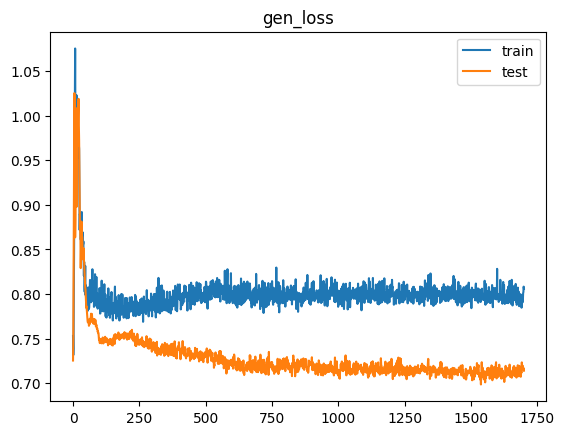

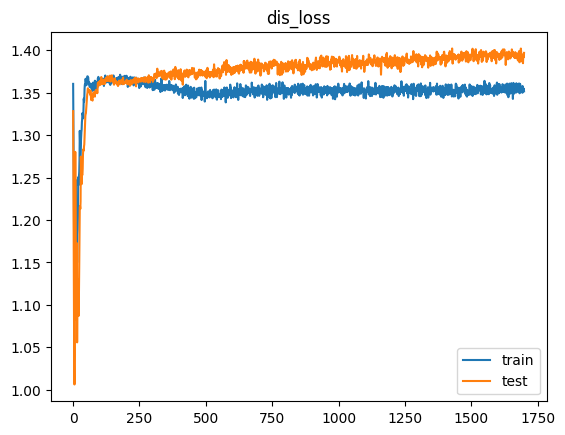

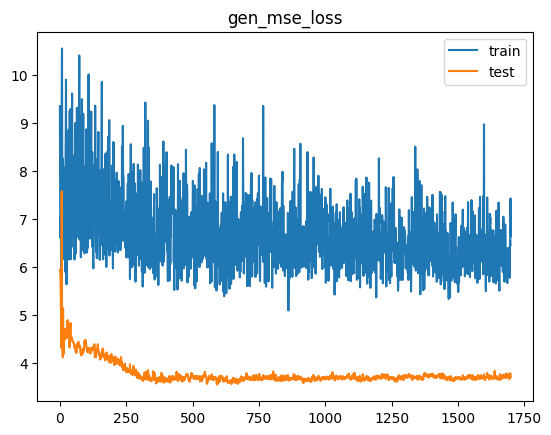

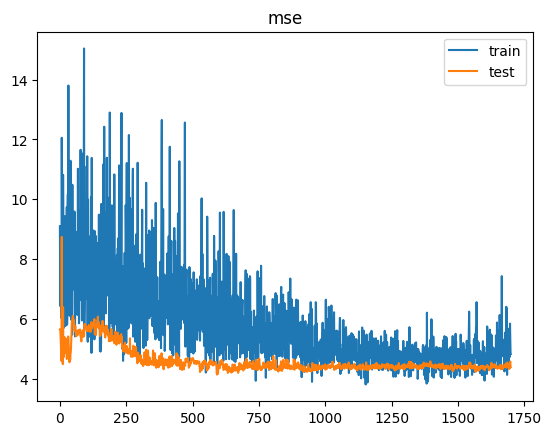

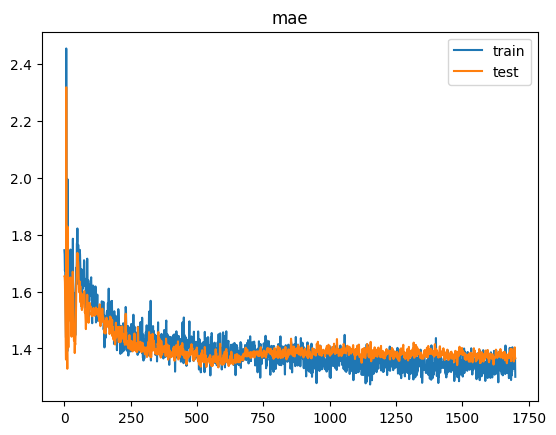

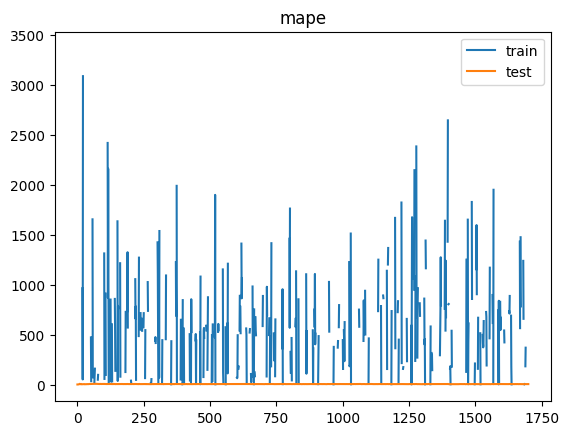

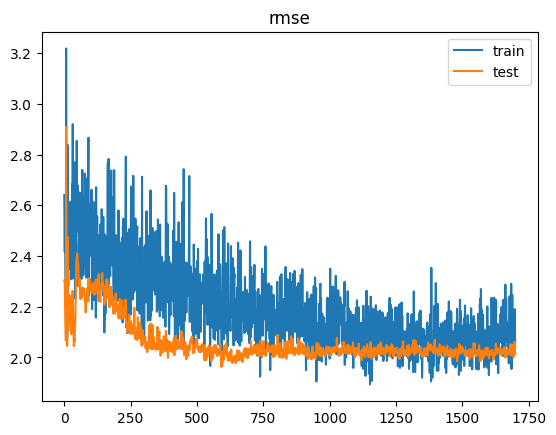

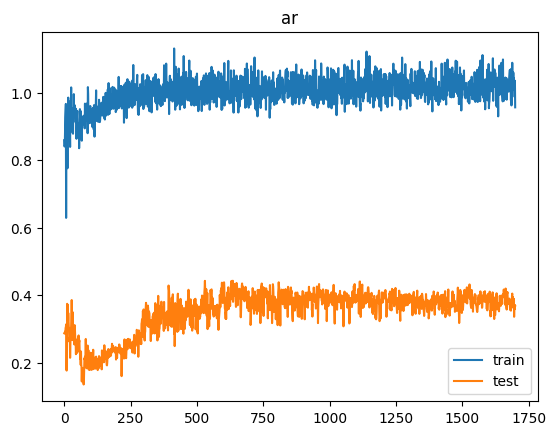

2/2 [==============================] - 0s 4ms/step


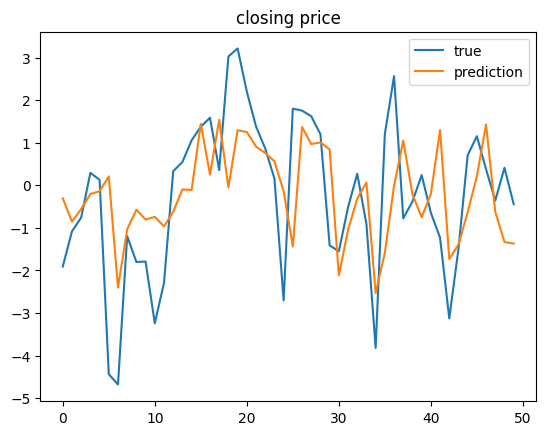

[MSE Baseline] train: 6.5294321813170155  test: 4.18451216814071
Delta time with epochs = 1700: 0:31:59.702037
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_14 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_35 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 1.1988601684570312 sec Generator Loss: 0.8266583681106567,  Discriminator_loss: 1.3602004051208496
Time for epoch 52 is 1.1777369976043701 sec Generator Loss: 0.8080187439918518,  Discriminator_loss: 1.3556231260299683
Time for epoch 53 is 1.2328524589538574 sec Generator Loss: 0.8363580703735352,  Discriminator_loss: 1.3583403825759888
Time for epoch 54 is 1.1920430660247803 sec Generator Loss: 0.7953365445137024,  Discriminator_loss: 1.3547019958496094
Time for epoch 55 is 1.1807494163513184 sec Generator Loss: 0.7885305285453796,  Discriminator_loss: 1.3654423952102661
Time for epoch 56 is 1.290705680847168 sec Generator Loss: 0.7990651726722717,  Discriminator_loss: 1.364662528038025
Time for epoch 57 is 1.3910439014434814 sec Generator Loss: 0.8011552095413208,  Discriminator_loss: 1.3601086139678955
Time for epoch 58 is 1.1917240619659424 sec Generator Loss: 0.7940524816513062,  Discriminator_loss: 1.3618422746658325
Time for epoch 59 is 1.2053759098052979 se

Time for epoch 120 is 1.1721866130828857 sec Generator Loss: 0.7847940325737,  Discriminator_loss: 1.3580551147460938
Time for epoch 121 is 1.175128698348999 sec Generator Loss: 0.8097801804542542,  Discriminator_loss: 1.3574554920196533
Time for epoch 122 is 1.4201581478118896 sec Generator Loss: 0.8092530369758606,  Discriminator_loss: 1.362373948097229
Time for epoch 123 is 1.4471681118011475 sec Generator Loss: 0.7870514392852783,  Discriminator_loss: 1.357398271560669
Time for epoch 124 is 1.3686919212341309 sec Generator Loss: 0.780044674873352,  Discriminator_loss: 1.3600436449050903
Time for epoch 125 is 1.5084664821624756 sec Generator Loss: 0.7903805375099182,  Discriminator_loss: 1.3573944568634033
Time for epoch 126 is 1.4144721031188965 sec Generator Loss: 0.7757712602615356,  Discriminator_loss: 1.3617931604385376
Time for epoch 127 is 1.344679832458496 sec Generator Loss: 0.7826712727546692,  Discriminator_loss: 1.363157033920288
Time for epoch 128 is 1.3745300769805908 

Time for epoch 189 is 1.4742813110351562 sec Generator Loss: 0.7933688759803772,  Discriminator_loss: 1.358443021774292
Time for epoch 190 is 1.3322689533233643 sec Generator Loss: 0.8043424487113953,  Discriminator_loss: 1.3553651571273804
Time for epoch 191 is 1.28071928024292 sec Generator Loss: 0.8027676939964294,  Discriminator_loss: 1.3589354753494263
Time for epoch 192 is 1.1998326778411865 sec Generator Loss: 0.7865769863128662,  Discriminator_loss: 1.3614635467529297
Time for epoch 193 is 1.184535264968872 sec Generator Loss: 0.7918656468391418,  Discriminator_loss: 1.3599704504013062
Time for epoch 194 is 1.2219243049621582 sec Generator Loss: 0.7824475765228271,  Discriminator_loss: 1.3656301498413086
Time for epoch 195 is 1.1411151885986328 sec Generator Loss: 0.8066486120223999,  Discriminator_loss: 1.3572989702224731
Time for epoch 196 is 1.2126619815826416 sec Generator Loss: 0.7862047553062439,  Discriminator_loss: 1.3586020469665527
Time for epoch 197 is 1.459478378295

Time for epoch 258 is 1.178985834121704 sec Generator Loss: 0.7842254042625427,  Discriminator_loss: 1.3557456731796265
Time for epoch 259 is 1.1688060760498047 sec Generator Loss: 0.8089146018028259,  Discriminator_loss: 1.354706048965454
Time for epoch 260 is 1.1484713554382324 sec Generator Loss: 0.7962087392807007,  Discriminator_loss: 1.355055809020996
Time for epoch 261 is 1.2124884128570557 sec Generator Loss: 0.8241831660270691,  Discriminator_loss: 1.3543320894241333
Time for epoch 262 is 1.1442687511444092 sec Generator Loss: 0.7954211235046387,  Discriminator_loss: 1.3554130792617798
Time for epoch 263 is 1.1523873805999756 sec Generator Loss: 0.7871747016906738,  Discriminator_loss: 1.358310580253601
Time for epoch 264 is 1.2418076992034912 sec Generator Loss: 0.7885832786560059,  Discriminator_loss: 1.3604458570480347
Time for epoch 265 is 1.1518914699554443 sec Generator Loss: 0.8087263107299805,  Discriminator_loss: 1.352240800857544
Time for epoch 266 is 1.1269042491912

Time for epoch 326 is 1.3005194664001465 sec Generator Loss: 0.7894639372825623,  Discriminator_loss: 1.3542641401290894
Time for epoch 327 is 1.294055461883545 sec Generator Loss: 0.7841269373893738,  Discriminator_loss: 1.349365472793579
Time for epoch 328 is 1.2719388008117676 sec Generator Loss: 0.7906210422515869,  Discriminator_loss: 1.3529826402664185
Time for epoch 329 is 1.20888090133667 sec Generator Loss: 0.7920659780502319,  Discriminator_loss: 1.351636528968811
Time for epoch 330 is 1.1823725700378418 sec Generator Loss: 0.7920771837234497,  Discriminator_loss: 1.3502531051635742
Time for epoch 331 is 1.1896727085113525 sec Generator Loss: 0.8148204684257507,  Discriminator_loss: 1.3476499319076538
Time for epoch 332 is 1.1704914569854736 sec Generator Loss: 0.8030715584754944,  Discriminator_loss: 1.3516263961791992
Time for epoch 333 is 1.2447803020477295 sec Generator Loss: 0.8050665855407715,  Discriminator_loss: 1.353093147277832
Time for epoch 334 is 1.18595504760742

Time for epoch 395 is 1.3942391872406006 sec Generator Loss: 0.800722599029541,  Discriminator_loss: 1.3413457870483398
Time for epoch 396 is 1.3405225276947021 sec Generator Loss: 0.8200536966323853,  Discriminator_loss: 1.343592882156372
Time for epoch 397 is 1.2647051811218262 sec Generator Loss: 0.8112006783485413,  Discriminator_loss: 1.3413307666778564
Time for epoch 398 is 1.2022926807403564 sec Generator Loss: 0.8037934899330139,  Discriminator_loss: 1.3501687049865723
Time for epoch 399 is 1.1916344165802002 sec Generator Loss: 0.806037187576294,  Discriminator_loss: 1.3386815786361694
Time for epoch 400 is 1.2081923484802246 sec Generator Loss: 0.8226938843727112,  Discriminator_loss: 1.3484466075897217
Time for epoch 401 is 1.191974401473999 sec Generator Loss: 0.8006580471992493,  Discriminator_loss: 1.350237488746643
Time for epoch 402 is 1.160032033920288 sec Generator Loss: 0.7985938787460327,  Discriminator_loss: 1.3447445631027222
Time for epoch 403 is 1.34803676605224

Time for epoch 464 is 1.2698595523834229 sec Generator Loss: 0.8010474443435669,  Discriminator_loss: 1.3428773880004883
Time for epoch 465 is 1.2140727043151855 sec Generator Loss: 0.8069854974746704,  Discriminator_loss: 1.3482692241668701
Time for epoch 466 is 1.2024447917938232 sec Generator Loss: 0.8093277812004089,  Discriminator_loss: 1.3463571071624756
Time for epoch 467 is 1.3882112503051758 sec Generator Loss: 0.7960615754127502,  Discriminator_loss: 1.3478288650512695
Time for epoch 468 is 1.4629194736480713 sec Generator Loss: 0.8042608499526978,  Discriminator_loss: 1.3496277332305908
Time for epoch 469 is 1.3183116912841797 sec Generator Loss: 0.7939737439155579,  Discriminator_loss: 1.3495914936065674
Time for epoch 470 is 1.6014974117279053 sec Generator Loss: 0.8053388595581055,  Discriminator_loss: 1.339529037475586
Time for epoch 471 is 1.6533353328704834 sec Generator Loss: 0.8232441544532776,  Discriminator_loss: 1.3421823978424072
Time for epoch 472 is 1.473028421

Time for epoch 533 is 1.1298820972442627 sec Generator Loss: 0.8178982138633728,  Discriminator_loss: 1.3453820943832397
Time for epoch 534 is 1.2155838012695312 sec Generator Loss: 0.80331951379776,  Discriminator_loss: 1.3463126420974731
Time for epoch 535 is 1.1478004455566406 sec Generator Loss: 0.815237283706665,  Discriminator_loss: 1.3451308012008667
Time for epoch 536 is 1.139808177947998 sec Generator Loss: 0.812082052230835,  Discriminator_loss: 1.3426364660263062
Time for epoch 537 is 1.1658155918121338 sec Generator Loss: 0.8043720126152039,  Discriminator_loss: 1.3433729410171509
Time for epoch 538 is 1.1832566261291504 sec Generator Loss: 0.8090511560440063,  Discriminator_loss: 1.3429330587387085
Time for epoch 539 is 1.221179723739624 sec Generator Loss: 0.828138530254364,  Discriminator_loss: 1.3458184003829956
Time for epoch 540 is 1.2374637126922607 sec Generator Loss: 0.8201459050178528,  Discriminator_loss: 1.344009280204773
Time for epoch 541 is 1.1596810817718506

Time for epoch 602 is 1.1824193000793457 sec Generator Loss: 0.8149898052215576,  Discriminator_loss: 1.3410171270370483
Time for epoch 603 is 1.205887794494629 sec Generator Loss: 0.810745894908905,  Discriminator_loss: 1.3374755382537842
Time for epoch 604 is 1.2842581272125244 sec Generator Loss: 0.8186847567558289,  Discriminator_loss: 1.3413045406341553
Time for epoch 605 is 1.3006792068481445 sec Generator Loss: 0.8154934048652649,  Discriminator_loss: 1.3381867408752441
Time for epoch 606 is 1.2279341220855713 sec Generator Loss: 0.8147520422935486,  Discriminator_loss: 1.3454288244247437
Time for epoch 607 is 1.362809181213379 sec Generator Loss: 0.8292762041091919,  Discriminator_loss: 1.3368728160858154
Time for epoch 608 is 1.3398621082305908 sec Generator Loss: 0.8145668506622314,  Discriminator_loss: 1.3435648679733276
Time for epoch 609 is 1.289323329925537 sec Generator Loss: 0.8005723357200623,  Discriminator_loss: 1.348806619644165
Time for epoch 610 is 1.3796675205230

Time for epoch 671 is 1.1278910636901855 sec Generator Loss: 0.8163342475891113,  Discriminator_loss: 1.3420398235321045
Time for epoch 672 is 1.1724555492401123 sec Generator Loss: 0.828581690788269,  Discriminator_loss: 1.3460593223571777
Time for epoch 673 is 1.2171118259429932 sec Generator Loss: 0.8245871067047119,  Discriminator_loss: 1.3445186614990234
Time for epoch 674 is 1.1605489253997803 sec Generator Loss: 0.8157796263694763,  Discriminator_loss: 1.342673897743225
Time for epoch 675 is 1.1992168426513672 sec Generator Loss: 0.8127754926681519,  Discriminator_loss: 1.342727780342102
Time for epoch 676 is 1.2269537448883057 sec Generator Loss: 0.8143713474273682,  Discriminator_loss: 1.3429110050201416
Time for epoch 677 is 1.1973786354064941 sec Generator Loss: 0.8116950392723083,  Discriminator_loss: 1.3435717821121216
Time for epoch 678 is 1.156296968460083 sec Generator Loss: 0.8032362461090088,  Discriminator_loss: 1.3414218425750732
Time for epoch 679 is 1.216534376144

Time for epoch 739 is 1.1988754272460938 sec Generator Loss: 0.8190017342567444,  Discriminator_loss: 1.3351727724075317
Time for epoch 740 is 1.2258105278015137 sec Generator Loss: 0.822257399559021,  Discriminator_loss: 1.339911937713623
Time for epoch 741 is 1.1309258937835693 sec Generator Loss: 0.8146988749504089,  Discriminator_loss: 1.3440049886703491
Time for epoch 742 is 1.1824567317962646 sec Generator Loss: 0.8124464750289917,  Discriminator_loss: 1.345466136932373
Time for epoch 743 is 1.1435375213623047 sec Generator Loss: 0.8062745332717896,  Discriminator_loss: 1.3427263498306274
Time for epoch 744 is 1.1784374713897705 sec Generator Loss: 0.8085760474205017,  Discriminator_loss: 1.3406639099121094
Time for epoch 745 is 1.202038288116455 sec Generator Loss: 0.8051053881645203,  Discriminator_loss: 1.3462146520614624
Time for epoch 746 is 1.1642704010009766 sec Generator Loss: 0.8346437215805054,  Discriminator_loss: 1.3374624252319336
Time for epoch 747 is 1.161852121353

Time for epoch 807 is 1.3962407112121582 sec Generator Loss: 0.8242018818855286,  Discriminator_loss: 1.3407617807388306
Time for epoch 808 is 1.2803452014923096 sec Generator Loss: 0.8111667037010193,  Discriminator_loss: 1.3410475254058838
Time for epoch 809 is 1.5518085956573486 sec Generator Loss: 0.8088550567626953,  Discriminator_loss: 1.3362128734588623
Time for epoch 810 is 1.442586898803711 sec Generator Loss: 0.8298835754394531,  Discriminator_loss: 1.3409579992294312
Time for epoch 811 is 1.357576847076416 sec Generator Loss: 0.8428685069084167,  Discriminator_loss: 1.3400933742523193
Time for epoch 812 is 1.1857059001922607 sec Generator Loss: 0.8175807595252991,  Discriminator_loss: 1.3431766033172607
Time for epoch 813 is 1.1913857460021973 sec Generator Loss: 0.8191394805908203,  Discriminator_loss: 1.336923360824585
Time for epoch 814 is 1.1717047691345215 sec Generator Loss: 0.8062179684638977,  Discriminator_loss: 1.3418011665344238
Time for epoch 815 is 1.21512794494

Time for epoch 876 is 1.154261827468872 sec Generator Loss: 0.8252373337745667,  Discriminator_loss: 1.3393369913101196
Time for epoch 877 is 1.209322452545166 sec Generator Loss: 0.8195282220840454,  Discriminator_loss: 1.336228609085083
Time for epoch 878 is 1.3153433799743652 sec Generator Loss: 0.8167757391929626,  Discriminator_loss: 1.3404045104980469
Time for epoch 879 is 1.3329107761383057 sec Generator Loss: 0.8383183479309082,  Discriminator_loss: 1.351704716682434
Time for epoch 880 is 1.3107686042785645 sec Generator Loss: 0.815538227558136,  Discriminator_loss: 1.345571756362915
Time for epoch 881 is 1.3576197624206543 sec Generator Loss: 0.8109118938446045,  Discriminator_loss: 1.3479470014572144
Time for epoch 882 is 1.369265079498291 sec Generator Loss: 0.8332931995391846,  Discriminator_loss: 1.340977668762207
Time for epoch 883 is 1.3263099193572998 sec Generator Loss: 0.8244174718856812,  Discriminator_loss: 1.3371360301971436
Time for epoch 884 is 1.3266527652740479

Time for epoch 945 is 1.3004791736602783 sec Generator Loss: 0.8358604907989502,  Discriminator_loss: 1.3363884687423706
Time for epoch 946 is 1.2799570560455322 sec Generator Loss: 0.8184728622436523,  Discriminator_loss: 1.3417153358459473
Time for epoch 947 is 1.2252156734466553 sec Generator Loss: 0.8109341859817505,  Discriminator_loss: 1.3382456302642822
Time for epoch 948 is 1.1759960651397705 sec Generator Loss: 0.8154136538505554,  Discriminator_loss: 1.3418258428573608
Time for epoch 949 is 1.1838343143463135 sec Generator Loss: 0.8151839375495911,  Discriminator_loss: 1.3404959440231323
Time for epoch 950 is 1.2312872409820557 sec Generator Loss: 0.8188625574111938,  Discriminator_loss: 1.3438628911972046
Time for epoch 951 is 1.1751739978790283 sec Generator Loss: 0.8052625060081482,  Discriminator_loss: 1.3448140621185303
Time for epoch 952 is 1.2171576023101807 sec Generator Loss: 0.8326070308685303,  Discriminator_loss: 1.3426376581192017
Time for epoch 953 is 1.23564720

Time for epoch 1013 is 1.2496659755706787 sec Generator Loss: 0.8121711015701294,  Discriminator_loss: 1.3455839157104492
Time for epoch 1014 is 1.1990776062011719 sec Generator Loss: 0.8125064373016357,  Discriminator_loss: 1.3485348224639893
Time for epoch 1015 is 1.162822961807251 sec Generator Loss: 0.8332371115684509,  Discriminator_loss: 1.3398524522781372
Time for epoch 1016 is 1.18748140335083 sec Generator Loss: 0.8256493806838989,  Discriminator_loss: 1.3421971797943115
Time for epoch 1017 is 1.2459282875061035 sec Generator Loss: 0.8220933079719543,  Discriminator_loss: 1.3355786800384521
Time for epoch 1018 is 1.1999435424804688 sec Generator Loss: 0.8147928714752197,  Discriminator_loss: 1.338291883468628
Time for epoch 1019 is 1.1872940063476562 sec Generator Loss: 0.8251570463180542,  Discriminator_loss: 1.345360517501831
Time for epoch 1020 is 1.2291500568389893 sec Generator Loss: 0.8094764947891235,  Discriminator_loss: 1.3404022455215454
Time for epoch 1021 is 1.2959

Time for epoch 1081 is 1.3009426593780518 sec Generator Loss: 0.8307593464851379,  Discriminator_loss: 1.3373538255691528
Time for epoch 1082 is 1.2890675067901611 sec Generator Loss: 0.813404381275177,  Discriminator_loss: 1.3442240953445435
Time for epoch 1083 is 1.2481369972229004 sec Generator Loss: 0.8311865329742432,  Discriminator_loss: 1.3398654460906982
Time for epoch 1084 is 1.2594945430755615 sec Generator Loss: 0.808558464050293,  Discriminator_loss: 1.3493590354919434
Time for epoch 1085 is 1.327240228652954 sec Generator Loss: 0.8199061751365662,  Discriminator_loss: 1.3420716524124146
Time for epoch 1086 is 1.2325832843780518 sec Generator Loss: 0.8144172430038452,  Discriminator_loss: 1.3438509702682495
Time for epoch 1087 is 1.2889790534973145 sec Generator Loss: 0.8122742772102356,  Discriminator_loss: 1.3420145511627197
Time for epoch 1088 is 1.2292346954345703 sec Generator Loss: 0.8076083064079285,  Discriminator_loss: 1.3441247940063477
Time for epoch 1089 is 1.38

Time for epoch 1149 is 1.3715136051177979 sec Generator Loss: 0.8101264238357544,  Discriminator_loss: 1.3393200635910034
Time for epoch 1150 is 1.6475675106048584 sec Generator Loss: 0.8160560727119446,  Discriminator_loss: 1.3350305557250977
Time for epoch 1151 is 1.6704981327056885 sec Generator Loss: 0.8132100701332092,  Discriminator_loss: 1.349260926246643
Time for epoch 1152 is 1.4139020442962646 sec Generator Loss: 0.8190523386001587,  Discriminator_loss: 1.3424392938613892
Time for epoch 1153 is 1.4559285640716553 sec Generator Loss: 0.8237879276275635,  Discriminator_loss: 1.341185450553894
Time for epoch 1154 is 1.4878714084625244 sec Generator Loss: 0.8162434101104736,  Discriminator_loss: 1.343682885169983
Time for epoch 1155 is 1.276026725769043 sec Generator Loss: 0.8152097463607788,  Discriminator_loss: 1.341304063796997
Time for epoch 1156 is 1.19022798538208 sec Generator Loss: 0.8304650187492371,  Discriminator_loss: 1.3444443941116333
Time for epoch 1157 is 1.214378

Time for epoch 1217 is 1.2327461242675781 sec Generator Loss: 0.8133403658866882,  Discriminator_loss: 1.346727728843689
Time for epoch 1218 is 1.218137502670288 sec Generator Loss: 0.8150830268859863,  Discriminator_loss: 1.3493143320083618
Time for epoch 1219 is 1.1855614185333252 sec Generator Loss: 0.8380646705627441,  Discriminator_loss: 1.342481017112732
Time for epoch 1220 is 1.2370314598083496 sec Generator Loss: 0.823742687702179,  Discriminator_loss: 1.3426635265350342
Time for epoch 1221 is 1.2917518615722656 sec Generator Loss: 0.811280369758606,  Discriminator_loss: 1.3433641195297241
Time for epoch 1222 is 1.3636138439178467 sec Generator Loss: 0.8144894242286682,  Discriminator_loss: 1.343153715133667
Time for epoch 1223 is 1.2753033638000488 sec Generator Loss: 0.80829918384552,  Discriminator_loss: 1.3480472564697266
Time for epoch 1224 is 1.212585687637329 sec Generator Loss: 0.8090434670448303,  Discriminator_loss: 1.3460687398910522
Time for epoch 1225 is 1.35488867

Time for epoch 1285 is 1.201117753982544 sec Generator Loss: 0.8278888463973999,  Discriminator_loss: 1.3366544246673584
Time for epoch 1286 is 1.2158920764923096 sec Generator Loss: 0.809275209903717,  Discriminator_loss: 1.3480336666107178
Time for epoch 1287 is 1.186100959777832 sec Generator Loss: 0.838219165802002,  Discriminator_loss: 1.3417993783950806
Time for epoch 1288 is 1.231278419494629 sec Generator Loss: 0.8180184364318848,  Discriminator_loss: 1.3418630361557007
Time for epoch 1289 is 1.2088699340820312 sec Generator Loss: 0.8250608444213867,  Discriminator_loss: 1.3419575691223145
Time for epoch 1290 is 1.2218921184539795 sec Generator Loss: 0.8247351050376892,  Discriminator_loss: 1.3388800621032715
Time for epoch 1291 is 1.2281291484832764 sec Generator Loss: 0.8252901434898376,  Discriminator_loss: 1.3419380187988281
Time for epoch 1292 is 1.3264801502227783 sec Generator Loss: 0.8090671896934509,  Discriminator_loss: 1.3445546627044678
Time for epoch 1293 is 1.2305

Time for epoch 1353 is 1.3193693161010742 sec Generator Loss: 0.8145502209663391,  Discriminator_loss: 1.3468419313430786
Time for epoch 1354 is 1.416900634765625 sec Generator Loss: 0.8190299272537231,  Discriminator_loss: 1.3436799049377441
Time for epoch 1355 is 1.3450868129730225 sec Generator Loss: 0.8193376064300537,  Discriminator_loss: 1.3420659303665161
Time for epoch 1356 is 1.4175009727478027 sec Generator Loss: 0.8223132491111755,  Discriminator_loss: 1.3478561639785767
Time for epoch 1357 is 1.4280908107757568 sec Generator Loss: 0.8208467364311218,  Discriminator_loss: 1.3380128145217896
Time for epoch 1358 is 1.590489149093628 sec Generator Loss: 0.8349531888961792,  Discriminator_loss: 1.337961196899414
Time for epoch 1359 is 1.4415216445922852 sec Generator Loss: 0.8394121527671814,  Discriminator_loss: 1.3383253812789917
Time for epoch 1360 is 1.5102369785308838 sec Generator Loss: 0.8258224725723267,  Discriminator_loss: 1.3385909795761108
Time for epoch 1361 is 1.42

Time for epoch 1421 is 1.3688023090362549 sec Generator Loss: 0.8259212970733643,  Discriminator_loss: 1.345139741897583
Time for epoch 1422 is 1.2600765228271484 sec Generator Loss: 0.8139667510986328,  Discriminator_loss: 1.3436002731323242
Time for epoch 1423 is 1.312931776046753 sec Generator Loss: 0.8108460903167725,  Discriminator_loss: 1.3468369245529175
Time for epoch 1424 is 1.3617753982543945 sec Generator Loss: 0.8147477507591248,  Discriminator_loss: 1.3447811603546143
Time for epoch 1425 is 1.3111722469329834 sec Generator Loss: 0.8188732266426086,  Discriminator_loss: 1.3435676097869873
Time for epoch 1426 is 1.3304443359375 sec Generator Loss: 0.8315105438232422,  Discriminator_loss: 1.3396551609039307
Time for epoch 1427 is 1.2886128425598145 sec Generator Loss: 0.8195998072624207,  Discriminator_loss: 1.3433325290679932
Time for epoch 1428 is 1.272989273071289 sec Generator Loss: 0.8220335841178894,  Discriminator_loss: 1.3399502038955688
Time for epoch 1429 is 1.34350

Time for epoch 1489 is 1.455061435699463 sec Generator Loss: 0.8336125016212463,  Discriminator_loss: 1.3410409688949585
Time for epoch 1490 is 1.39479398727417 sec Generator Loss: 0.8148748278617859,  Discriminator_loss: 1.3443022966384888
Time for epoch 1491 is 1.4160621166229248 sec Generator Loss: 0.8224188685417175,  Discriminator_loss: 1.340066909790039
Time for epoch 1492 is 1.3944134712219238 sec Generator Loss: 0.8229112029075623,  Discriminator_loss: 1.3406133651733398
Time for epoch 1493 is 1.33551025390625 sec Generator Loss: 0.8154977560043335,  Discriminator_loss: 1.340479850769043
Time for epoch 1494 is 1.401050090789795 sec Generator Loss: 0.8085464239120483,  Discriminator_loss: 1.3445637226104736
Time for epoch 1495 is 1.4965174198150635 sec Generator Loss: 0.8059484362602234,  Discriminator_loss: 1.3464455604553223
Time for epoch 1496 is 1.3506274223327637 sec Generator Loss: 0.8151925802230835,  Discriminator_loss: 1.3458174467086792
Time for epoch 1497 is 1.3822922

Time for epoch 1557 is 1.3286714553833008 sec Generator Loss: 0.8118936419487,  Discriminator_loss: 1.3398234844207764
Time for epoch 1558 is 1.2590703964233398 sec Generator Loss: 0.8081420660018921,  Discriminator_loss: 1.3418655395507812
Time for epoch 1559 is 1.3132874965667725 sec Generator Loss: 0.8202876448631287,  Discriminator_loss: 1.3465237617492676
Time for epoch 1560 is 1.4614195823669434 sec Generator Loss: 0.8078508973121643,  Discriminator_loss: 1.3428932428359985
Time for epoch 1561 is 1.296257495880127 sec Generator Loss: 0.8255430459976196,  Discriminator_loss: 1.3392653465270996
Time for epoch 1562 is 1.3262064456939697 sec Generator Loss: 0.8062729835510254,  Discriminator_loss: 1.3492752313613892
Time for epoch 1563 is 1.2844271659851074 sec Generator Loss: 0.8220282196998596,  Discriminator_loss: 1.3455040454864502
Time for epoch 1564 is 1.3848917484283447 sec Generator Loss: 0.8063235282897949,  Discriminator_loss: 1.3471999168395996
Time for epoch 1565 is 1.296

Time for epoch 1625 is 1.427558422088623 sec Generator Loss: 0.8296607136726379,  Discriminator_loss: 1.3406158685684204
Time for epoch 1626 is 1.3969833850860596 sec Generator Loss: 0.8187228441238403,  Discriminator_loss: 1.34170663356781
Time for epoch 1627 is 1.4358088970184326 sec Generator Loss: 0.8008068799972534,  Discriminator_loss: 1.3504083156585693
Time for epoch 1628 is 1.4419341087341309 sec Generator Loss: 0.8337386846542358,  Discriminator_loss: 1.3387471437454224
Time for epoch 1629 is 1.4292612075805664 sec Generator Loss: 0.8183389902114868,  Discriminator_loss: 1.345558524131775
Time for epoch 1630 is 1.40336275100708 sec Generator Loss: 0.8250715732574463,  Discriminator_loss: 1.339686393737793
Time for epoch 1631 is 1.3783516883850098 sec Generator Loss: 0.8090954422950745,  Discriminator_loss: 1.3430492877960205
Time for epoch 1632 is 1.407010793685913 sec Generator Loss: 0.8134118914604187,  Discriminator_loss: 1.34256112575531
Time for epoch 1633 is 1.436395645

Time for epoch 1693 is 1.278200387954712 sec Generator Loss: 0.8004807829856873,  Discriminator_loss: 1.3502079248428345
Time for epoch 1694 is 1.3063325881958008 sec Generator Loss: 0.8144453167915344,  Discriminator_loss: 1.3408918380737305
Time for epoch 1695 is 1.4173855781555176 sec Generator Loss: 0.8079676032066345,  Discriminator_loss: 1.3457685708999634
Time for epoch 1696 is 1.2950763702392578 sec Generator Loss: 0.8148203492164612,  Discriminator_loss: 1.3468475341796875
Time for epoch 1697 is 1.3260273933410645 sec Generator Loss: 0.8243004083633423,  Discriminator_loss: 1.3428869247436523
Time for epoch 1698 is 1.2892019748687744 sec Generator Loss: 0.8211352229118347,  Discriminator_loss: 1.3456993103027344
Time for epoch 1699 is 1.4076883792877197 sec Generator Loss: 0.8136069774627686,  Discriminator_loss: 1.3480247259140015
Time for epoch 1700 is 1.2741193771362305 sec Generator Loss: 0.8230494856834412,  Discriminator_loss: 1.3438329696655273
Time for epoch 1701 is 1.

Time for epoch 1761 is 1.4196109771728516 sec Generator Loss: 0.8210031986236572,  Discriminator_loss: 1.3457505702972412
Time for epoch 1762 is 1.5244944095611572 sec Generator Loss: 0.8226548433303833,  Discriminator_loss: 1.339249849319458
Time for epoch 1763 is 1.3646495342254639 sec Generator Loss: 0.805679976940155,  Discriminator_loss: 1.349658727645874
Time for epoch 1764 is 1.3919422626495361 sec Generator Loss: 0.7946306467056274,  Discriminator_loss: 1.356189489364624
Time for epoch 1765 is 1.498453140258789 sec Generator Loss: 0.8004391193389893,  Discriminator_loss: 1.3459359407424927
Time for epoch 1766 is 1.4042274951934814 sec Generator Loss: 0.8102330565452576,  Discriminator_loss: 1.3416904211044312
Time for epoch 1767 is 1.461207389831543 sec Generator Loss: 0.7982087135314941,  Discriminator_loss: 1.3494861125946045
Time for epoch 1768 is 1.356182336807251 sec Generator Loss: 0.8301755785942078,  Discriminator_loss: 1.3389543294906616
Time for epoch 1769 is 1.328493

Time for epoch 1829 is 1.3270995616912842 sec Generator Loss: 0.8002592325210571,  Discriminator_loss: 1.349924087524414
Time for epoch 1830 is 1.2964277267456055 sec Generator Loss: 0.8148290514945984,  Discriminator_loss: 1.3471429347991943
Time for epoch 1831 is 1.3918745517730713 sec Generator Loss: 0.8124257326126099,  Discriminator_loss: 1.3479543924331665
Time for epoch 1832 is 1.3611812591552734 sec Generator Loss: 0.8088608980178833,  Discriminator_loss: 1.3502730131149292
Time for epoch 1833 is 1.3024682998657227 sec Generator Loss: 0.7998276948928833,  Discriminator_loss: 1.3505151271820068
Time for epoch 1834 is 1.3355836868286133 sec Generator Loss: 0.8055180311203003,  Discriminator_loss: 1.349234700202942
Time for epoch 1835 is 1.3598239421844482 sec Generator Loss: 0.8104822635650635,  Discriminator_loss: 1.3502542972564697
Time for epoch 1836 is 1.3336443901062012 sec Generator Loss: 0.8199244141578674,  Discriminator_loss: 1.3521093130111694
Time for epoch 1837 is 1.3

Time for epoch 1897 is 1.3218085765838623 sec Generator Loss: 0.8126726150512695,  Discriminator_loss: 1.343348503112793
Time for epoch 1898 is 1.3645708560943604 sec Generator Loss: 0.8163094520568848,  Discriminator_loss: 1.345861554145813
Time for epoch 1899 is 1.3282525539398193 sec Generator Loss: 0.8074265122413635,  Discriminator_loss: 1.3517359495162964
Time for epoch 1900 is 1.3857879638671875 sec Generator Loss: 0.8139926195144653,  Discriminator_loss: 1.3466181755065918
Time for epoch 1901 is 1.341050624847412 sec Generator Loss: 0.8039689064025879,  Discriminator_loss: 1.3444849252700806
Time for epoch 1902 is 1.3091437816619873 sec Generator Loss: 0.8061854243278503,  Discriminator_loss: 1.34250009059906
Time for epoch 1903 is 1.3177757263183594 sec Generator Loss: 0.8223862051963806,  Discriminator_loss: 1.3457850217819214
Time for epoch 1904 is 1.326077938079834 sec Generator Loss: 0.8086881637573242,  Discriminator_loss: 1.3471983671188354
Time for epoch 1905 is 1.33964

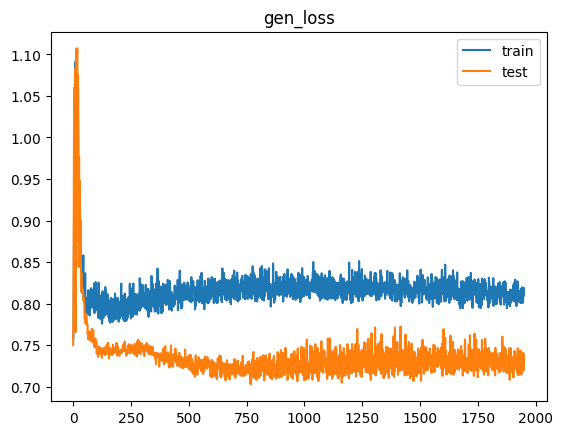

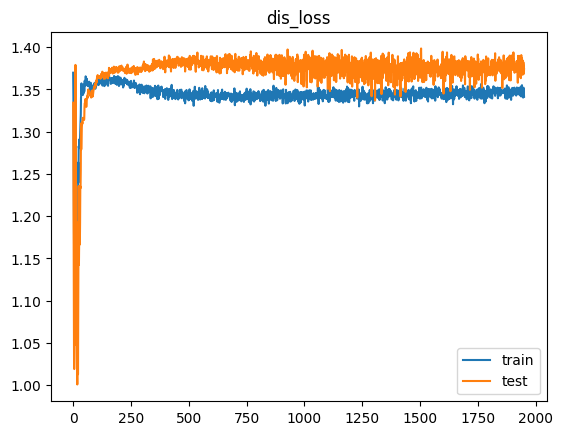

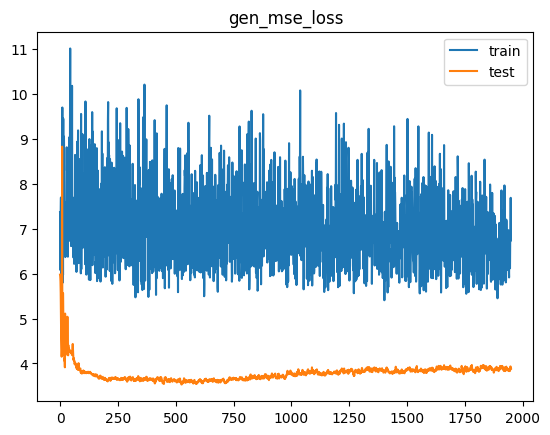

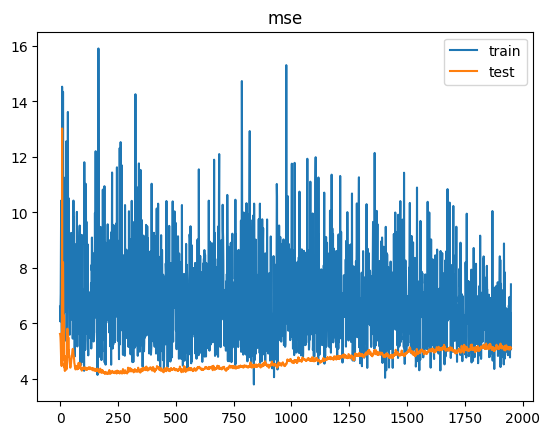

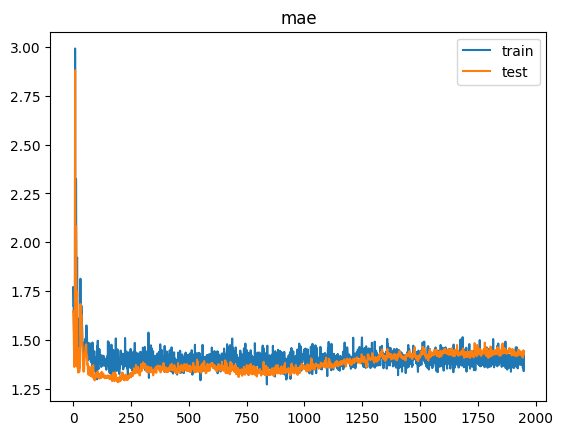

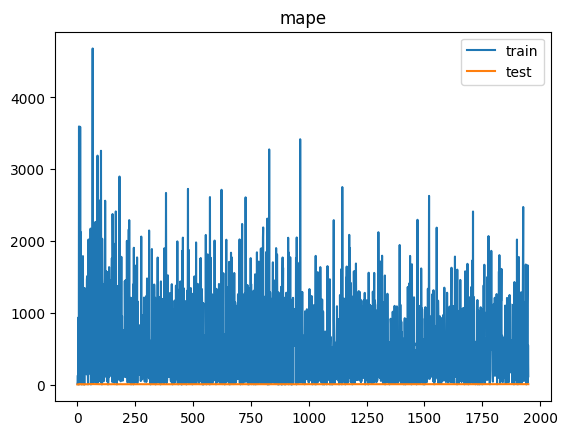

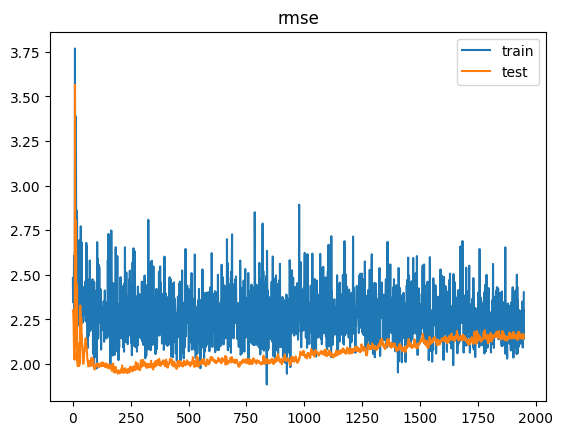

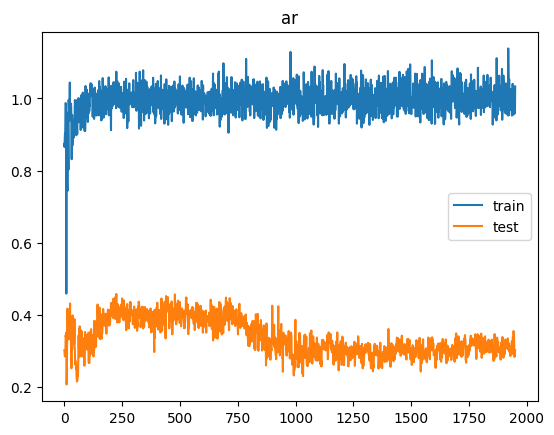

2/2 [==============================] - 1s 6ms/step


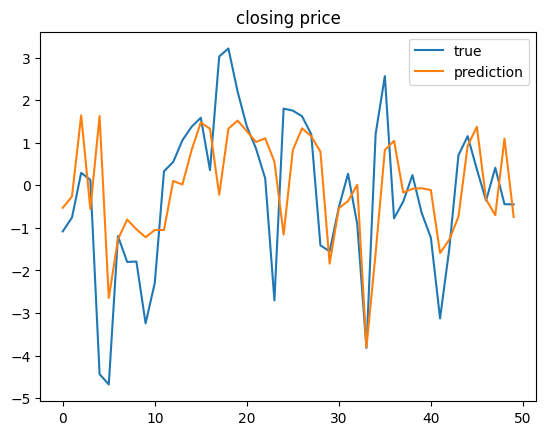

[MSE Baseline] train: 8.443173991940608  test: 4.203018036962421
Delta time with epochs = 1950: 0:42:20.233990


In [19]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))